# CIS5026 WRIT1: Airbnb Data Analysis
*ST20166622*

To run this notebook with the data, download the dataset from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/code) and adjust the first cell to enter the file location of the dataset.

## 1 The Business Analytical Question

In this notebook, the AirBnb summary data for New York is explored, transformed and analysed in order to answer the question, "what factors influence whether or not a listing is reviewed?".

### 1.1 Reasoning behind the business analytical question

The dataset explored in this notebook contains 20% listings that have never been reviewed. This implies that they have never been booked, but seems too high a proportion to be entirely explained by new listings. According to Airbnb's [website](https://www.airbnb.co.uk/help/article/39/what-factors-determine-how-my-listing-appears-in-search-results), when listings are sorted by the Airbnb search algorithm the number (as well as rating) of reviews is taken into account (Airbnb, 2020). Indeed, reviews are core to Airbnb's business strategy, as they mitigate the "perceived risk" of inviting complete strangers to stay in one another's homes (Reinhold and Dolnicar, 2018). As a result, the listings that have no reviews are less likely to be booked than those that do have reviews. If these are only the newest listings on the site then this is unlikely to be a problem, but if a relationship can be found between the presence of reviews and the other features in the dataset, this would imply that there is more to a listing's lack of bookings than its time on the market.

Of all of the features in the provided dataset, number of reviews is one of the strongest measures of "success" for a given listing. A host can supply any price they choose, but unless the listing is booked and subsequently reviewed, there is no way to know from this dataset whether or not guests are prepared to pay that price.

Because the listings without reviews were less likely to be booked, it seemed valuable to Airbnb to have a model that could identify these listings early, to prevent the hosts from finding themselves in a cycle of not having reviews making them less likely to get bookings.  The caveat for this model was that it must be interpretable, because of Jhaver *et al.*'s findings that hosts suffer "algorithmic anxiety" when their listings are inexplicably shifted down the search rankings by Airbnb's models. 

Therefore the goal of this investigation is to develop a model that would 

1. identify listings that would potentially never be booked; and
2. be interpretable, so that predictions could be expressed in terms of the features of the dataset.

These two qualities would make the model beneficial to:

- Airbnb executives, who would be able to use it to boost bookings of listings and increase revenue
- to hosts, who could be sent messages when their listing settings make them less likely to be booked, to support them in improving their visibility.

### About the dataset

The dataset is available on [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/code), where more than 500 notebooks have been submitted containing attempts to use the dataset for analysis, although many of these notebooks have been cloned from a smaller number. Of these notebooks, very few aim to predict the number of reviews or train classification models using the dataset. 

There are two suggested tasks on Kaggle: data analytics using Airbnb data, and predict NYC Airbnb rental prices (Kaggle, 2019).

The dataset comprises summary information about Airbnb listings in New York City as of August 2019.


## 2.1 Exploratory Data Analysis (EDA)

First, the required libraries and data are imported. Adjust the first cell (below) to include the path to the dataset on your machine.

In [148]:
path_to_dataset = 'data/AB_NYC_2019.csv'

In [146]:
# import libraries

import math, csv

from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix, make_scorer

from xgboost import XGBClassifier, plot_importance
import xgboost as xgb
import shap


In [154]:
# load data

airbnb = pd.read_csv(path_to_dataset)

airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [161]:
num_listings = len(airbnb)
num_listings_without_reviews = len(airbnb[airbnb['number_of_reviews']==0])
num_hosts = len(airbnb['host_id'].unique())
percent_no_reviews = round(num_listings_without_reviews/num_listings*100)

print(f'The data contains information about {num_listings} AirBnB listings from {num_hosts} hosts.',
      f'\nOf these listings, {num_listings_without_reviews} ({percent_no_reviews}%) do not have reviews.')

The data contains information about 48895 AirBnB listings from 37457 hosts. 
Of these listings, 10052 (21%) do not have reviews.


### 2.1.1 Missing values

In [4]:
# check for missing values

airbnb.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Some of these columns are irrelevant to the number of reviews being posted. For example, there's no mechanism by which id, host_name, and host_id could impact the number of reviews. The IDs are identifiers used to track the listings in other data sets (for example, AirBnb likely has data sets of reviews and host details). 

There may be information within the 'name' column that could influence the presence of reviews - for example, the name may list amenities such as a hot tub or garden that would make the listing more likely to be booked and then reviewed. However, this is beyond the scope of this project, so the name column will be removed from the dataset.

Therefore we can safely drop the columns `id`, `name`, `host_id`, and `host_name`, which will in turn address the missing values in `name` and `host_name`.

In [5]:
airbnb = airbnb.drop(['id', 'name', 'host_id', 'host_name'], axis = 1)
airbnb.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Let's investigate these missing values for `last review` and `reviews_per_month`

In [6]:
airbnb[airbnb['last_review'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [7]:
airbnb[airbnb['reviews_per_month'].isna()]['number_of_reviews'].value_counts()

0    10052
Name: number_of_reviews, dtype: int64

In [8]:
len(airbnb[airbnb['number_of_reviews']==0])

10052

The missing values correspond to rows where there are no reviews. In these cases there is no date of last review because there have been no reviews, and `reviews_per_month` cannot be calculated.

Therefore we can fill the missing values with 0. It won't make a difference, however, as `reviews_per_month` and `last_review` are so strongly correlated with `number of reviews` that we will not be using them as features in the model.

In [9]:
airbnb.fillna(0, inplace = True)
airbnb.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [10]:
airbnb.drop(columns = ['last_review', 'reviews_per_month'], inplace = True)
airbnb.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


In [162]:
airbnb.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Most of the features are numeric, with some continuous variables such as `latitude`, `longitude`, and `reviews_per_month`, and some integer variables such as `minimum_nights`, `price`, and `calculated_host_listing_count`. 

There are also a number of string variables, such as room type, which will need to be encoded as categorical variables if used.

### 2.1.2 Removal of outliers that are errors

The data is checked for obvious errors, for example:

- price less than or equal to $0
- availability (measured out of 365) greater than 365 or less than 0


In [11]:
airbnb[airbnb['price']<=0]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
23161,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,4,28
25433,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,4,127
25634,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,5,0
25753,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2,0
25778,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,1,73
25794,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,1,93,6,176
25795,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,1,95,6,232
25796,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,6,222
26259,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0,3,0,1,0
26841,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,30,2,6,333


In [12]:
# remove these values from the dataset.
airbnb = airbnb[airbnb['price']>0]

In [13]:
airbnb[airbnb['availability_365']<0]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365


In [14]:
airbnb[airbnb['availability_365']>365]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365


### 2.1.2 Split training and test data

At this point we should separate our training data from our test data. We will note all of the steps we perform on the training data and repeat them on the test data. This prevents information leakage from the test set **(CITE)**.


In [15]:
airbnb, final_test_set = train_test_split(airbnb, random_state = 42, test_size = 0.1)

# Because we will be testing downsampling and outlier removal techniques we will need as large a training set as possible
raw_train, raw_test = train_test_split(airbnb, random_state = 42, test_size = 0.1)
raw_train.head()

print(len(airbnb))
print(len(raw_train))
print(len(raw_test))
print(len(final_test_set))

43995
39595
4400
4889


### 2.1.3 Encode the Target Variable

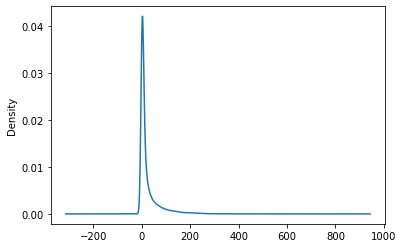

In [16]:
airbnb['number_of_reviews'].plot(kind = 'density');

Because we are looking to target listings that have received no reviews, it makes more sense to covert the number of reviews into binary classes (1 for 'has reviews' and 0 for 'does not have reviews')

In [17]:
# Encode target variable as 0 (no reviews) or 1 (reviews)

def encode_target(df: pd.DataFrame) -> pd.DataFrame:
    feature_col = 'number_of_reviews'
    new_df = df.copy()
    new_df['has_reviews'] = df[feature_col].apply(lambda r: 0 if r == 0 else 1)
    return new_df.drop(columns = [feature_col])

raw_train = encode_target(raw_train)
raw_test = encode_target(raw_test)

In [18]:
"""
Make a copy of the training data to explore during EDA. 
We can try transformations on this dataset to see if they improve the distributions. 
If they work, apply them to the training and test sets.
"""
eda_data = raw_train.copy()

### 2.1.4 EDA

Next, examine the distribution of numeric features.

In [19]:
### Numerical attributes

numerical_data = eda_data.select_dtypes('number')
#sns.pairplot(numerical_data, hue = 'has_reviews');

**comment on this**

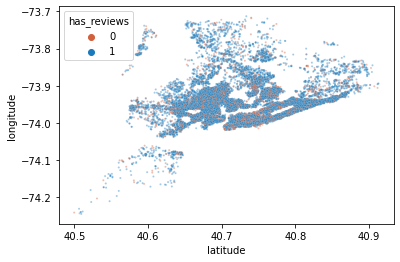

In [20]:
palette = {
    1: '#197BBD',
    0: '#D1603D'
}
fig, ax = plt.subplots()
sns.scatterplot(data = eda_data, x = 'latitude', y = 'longitude', hue = 'has_reviews', alpha = 0.4, s = 4, palette = palette);

In [21]:
def plot_distribution(df, col_of_interest, title = None, color_split = 'has_reviews', fontsize = 14):
    if title == None:
        title = "Distribution of "+ col_of_interest.replace('_', ' ') + " of AirBnB listings in New York City"
    fig, ax = plt.subplots(figsize = (10,8))
    ax.set_title(title, fontsize = fontsize)
    df[df[color_split]==1][col_of_interest].plot(kind = 'density', ax = ax, label = 'has reviews')
    df[df[color_split]==0][col_of_interest].plot(kind = 'density', ax = ax, label = 'does not have reviews')
    ax.plot(df[col_of_interest], [-0.0001]*len(df[col_of_interest]), '|', color='k')
    ax.legend(fontsize = 14)
    ax.set_xlabel(col_of_interest.title(), fontsize = fontsize)
    ax.set_ylabel('Density', fontsize = fontsize);
    return ax

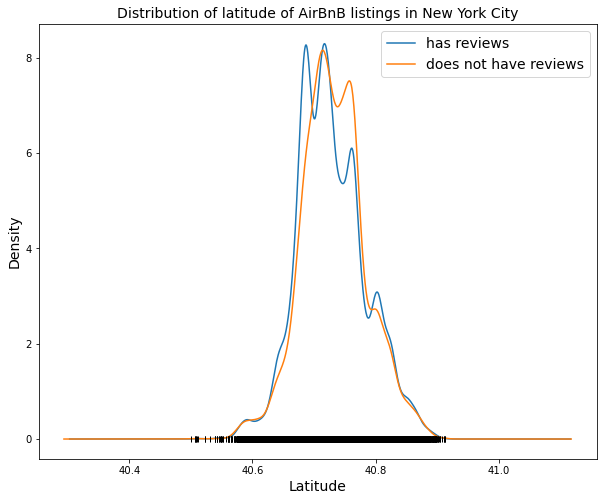

In [22]:
plot_distribution(eda_data, 'latitude');

<AxesSubplot:title={'center':'Distribution of longitude of AirBnB listings in New York City'}, xlabel='Longitude', ylabel='Density'>

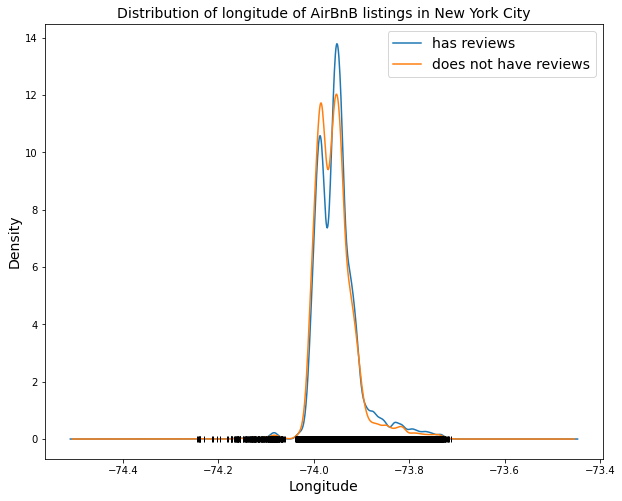

In [23]:
plot_distribution(eda_data, 'longitude')

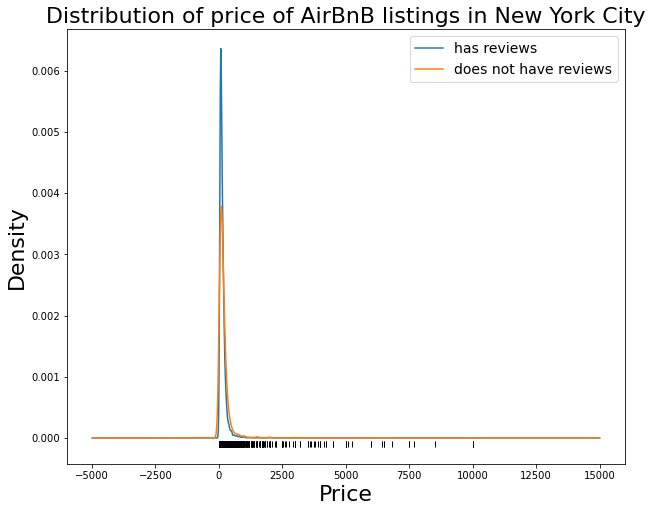

In [24]:
plot_distribution(eda_data, 'price', fontsize = 22);

The price distribution looks like it might be log normal. Transform it to get a normally distributed variable.

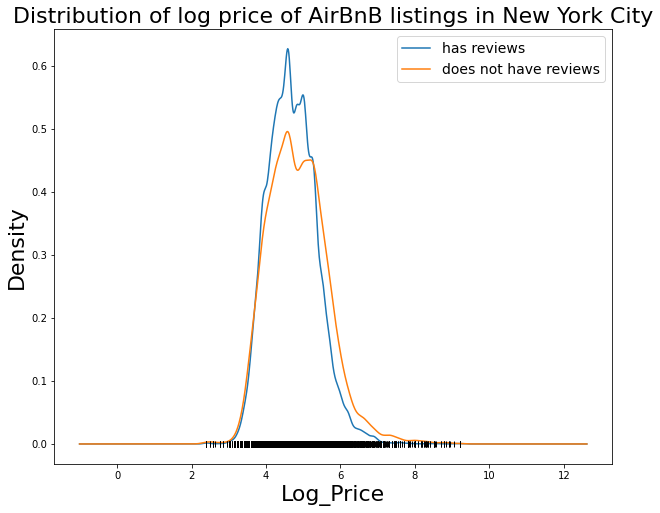

In [25]:
eda_data['log_price'] = eda_data['price'].apply(lambda p: np.log(p+1))
plot_distribution(eda_data, 'log_price', fontsize = 22);

The natural logarithm of price is approximately normally distributed.

<AxesSubplot:title={'center':'Distribution of availability of AirBnB listings (days out of 365)'}, xlabel='Availability_365', ylabel='Density'>

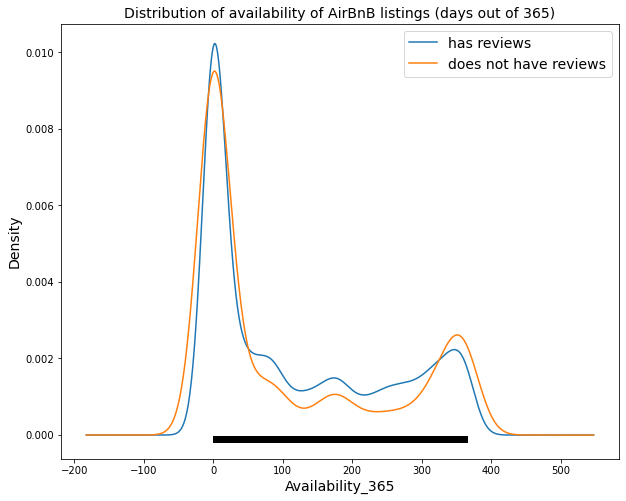

In [26]:
plot_distribution(eda_data, 'availability_365', title = 'Distribution of availability of AirBnB listings (days out of 365)')

It seems that a high proportion of listings are not actually available (availability = 0). These listings will be examined more closely. If they are not available now, have they ever been available? If any of them have reviews, it would imply that they have been available in the past.

In [27]:
eda_data[eda_data['availability_365']==0][['availability_365', 'has_reviews']].groupby(['has_reviews']).count()

,availability_365
has_reviews,
0,3871
1,10270


Many of the listings that are unavailable still have reviews. This suggests that at the time of the review(s), their availability was greater than 0. Going forward, we should bear in mind that the availability of the listings changes over time and we only have access to the value of availability at a single point in time. This might make the `availability_365` feature unreliable.

Make the data continuous by converting to the fraction of the year when the listing is available.

<AxesSubplot:title={'center':'Distribution of availability frac of AirBnB listings in New York City'}, xlabel='Availability_Frac', ylabel='Density'>

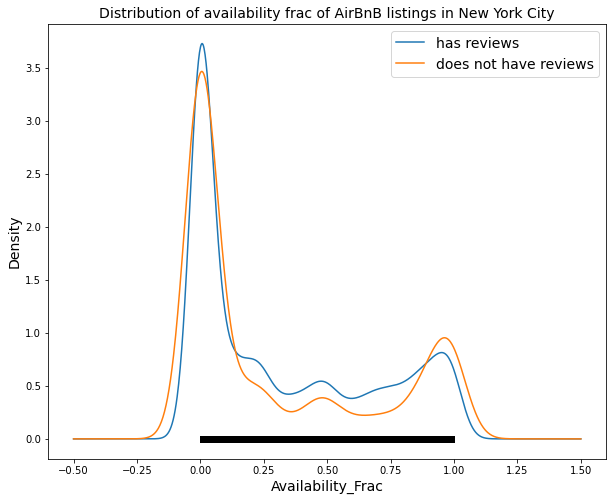

In [28]:
eda_data['availability_frac'] = eda_data['availability_365'] / 365
plot_distribution(eda_data, 'availability_frac')

<AxesSubplot:title={'center':'Distribution of calculated host listings count of AirBnB listings in New York City'}, xlabel='Calculated_Host_Listings_Count', ylabel='Density'>

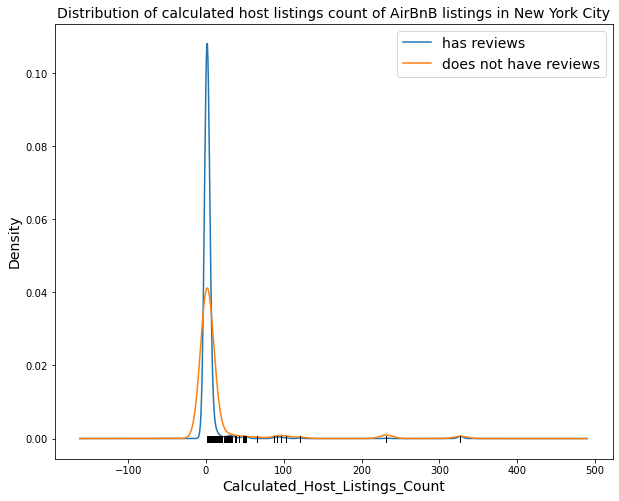

In [29]:
plot_distribution(eda_data, 'calculated_host_listings_count')

Again, this looks like a log normal distribution with some very large outliers.

<AxesSubplot:title={'center':'Distribution of log calculated host listings count of AirBnB listings in New York City'}, xlabel='Log_Calculated_Host_Listings_Count', ylabel='Density'>

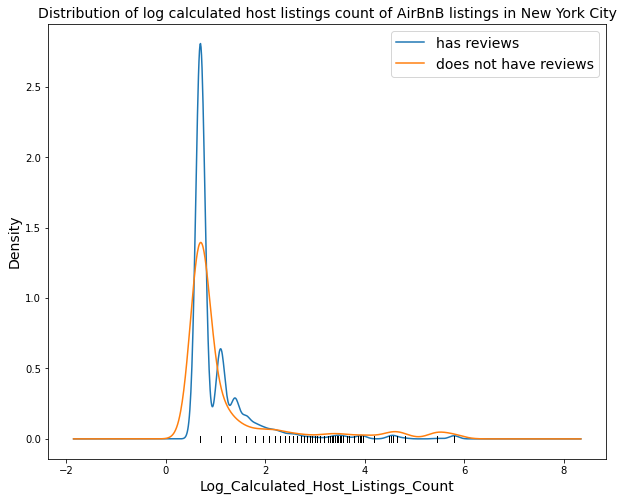

In [30]:
# since we are now performing log twice we should create a function that we will apply to the test and training data.
def transform_log_normal_variables(df: pd.DataFrame, columns_to_transform: List[str], drop = True) -> pd.DataFrame:
    new_df = df.copy()
    for col in columns_to_transform:
        new_column = 'log_' + col
        new_df[new_column] = new_df[col].apply(lambda x: np.log(x+1)) # prevent ln 0 errors
    if drop:
        new_df.drop(columns = columns_to_transform, inplace = True)
    return new_df

eda_data = transform_log_normal_variables(eda_data, ['calculated_host_listings_count'], drop = False)
plot_distribution(eda_data, 'log_calculated_host_listings_count')

On inspection it does not appear to be a log normal distribution. The data is bounded by 0 and has a long tail in the positive direction.

In [31]:
eda_data.drop(columns= ['log_calculated_host_listings_count'], inplace = True)

<AxesSubplot:title={'center':'Distribution of minimum nights of AirBnB listings in New York City'}, xlabel='Minimum_Nights', ylabel='Density'>

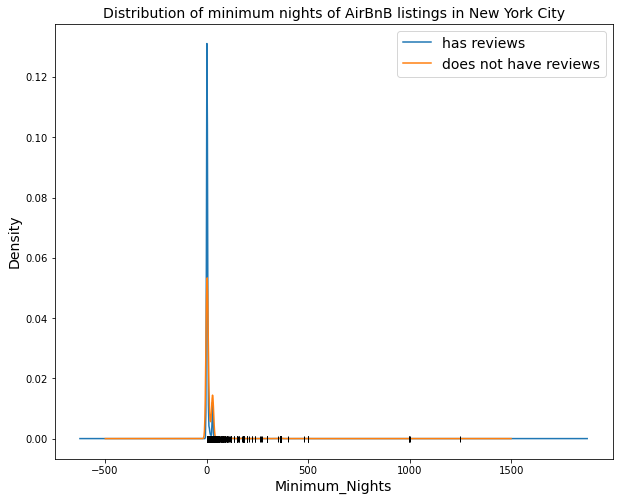

In [32]:
plot_distribution(eda_data, 'minimum_nights')

This variable also has some extreme outliers.

Minimum nights greater than a few month lean more towards tenancy than holiday stay.

We will create an OutlierRemover than can be used to strip outliers from the training data to see if it improves model performance. For visualisation purposes the outliers will be removed.

<AxesSubplot:title={'center':'Distribution of availability 365 of AirBnB listings in New York City'}, xlabel='Availability_365', ylabel='Density'>

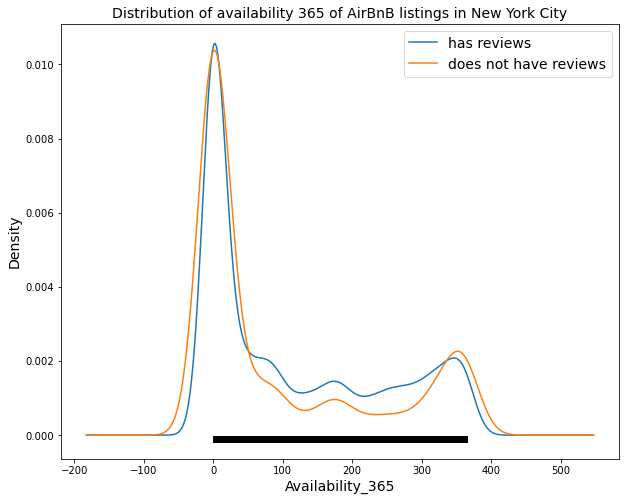

In [33]:
class OutlierRemover:
    def __init__(self, min_z_score = -3, max_z_score = 3):
        self.min_z_score = min_z_score
        self.max_z_score = max_z_score
        self.means_sds = {}
        self.list_of_columns = []
    def fit(self, data, list_of_columns = []):
        if len(list_of_columns)==0:
            list_of_columns = data.columns
        self.list_of_columns = list_of_columns
        for col in list_of_columns:
            mean = data[col].mean()
            sd = np.sqrt(data[col].var())
            self.means_sds[col] = (mean, sd)
    def calculate_z_score(self, value, col):
        return (value - self.means_sds[col][0])/self.means_sds[col][1]
    def transform(self, data):
        if len(self.means_sds.keys())==0:
            print("Transformer must be fit before transformation. Call .fit(data) or .fit_transform(data)")
            return
        for col in self.list_of_columns:
            z_scores = data[col].apply(self.calculate_z_score, col=col)
            keep = (z_scores>self.min_z_score)&(z_scores<self.max_z_score)
            data = data[keep]
        return data
    def fit_transform(self, data, list_of_cols = []):
        self.fit(data, list_of_cols)
        return self.transform(data)
    def get_outliers(self, data):
        if len(self.means_sds.keys())==0:
            print("Transformer must be fit before transformation. Call .fit(data) or .fit_transform(data)")
            return
        orig_data = data.copy()
        without_outliers = self.transform(data).index
        return orig_data[~orig_data.index.isin(without_outliers)]

o_r = OutlierRemover()

numerical_features = eda_data.select_dtypes('number')
eda_data[numerical_features.columns] = o_r.fit_transform(numerical_features)
plot_distribution(eda_data, 'availability_365')

<AxesSubplot:title={'center':'Distribution of minimum nights of AirBnB listings in New York City'}, xlabel='Minimum_Nights', ylabel='Density'>

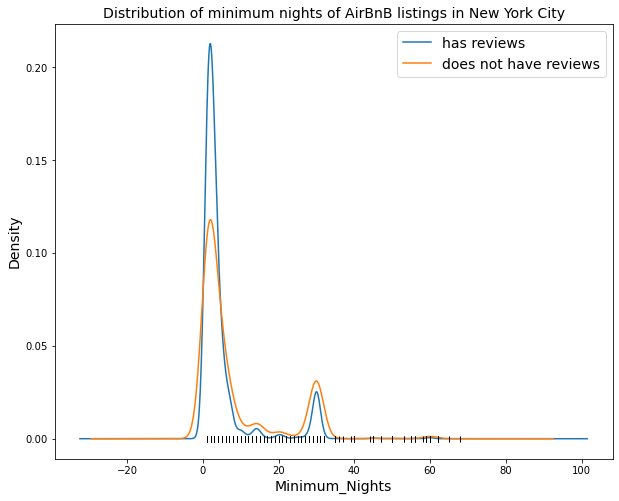

In [34]:
plot_distribution(eda_data, 'minimum_nights')

### Categorical features

In [35]:
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac
4426,Brooklyn,Williamsburg,40.71756,-73.95579,Entire home/apt,165.0,8.0,1.0,297.0,1.0,5.111988,0.813699
19742,Brooklyn,Bedford-Stuyvesant,40.68631,-73.92629,Private room,200.0,2.0,1.0,0.0,0.0,5.303305,0.000000
6251,Queens,Astoria,40.76413,-73.92374,Entire home/apt,98.0,6.0,1.0,306.0,1.0,4.595120,0.838356
31639,Brooklyn,Bushwick,40.69738,-73.92947,Entire home/apt,160.0,3.0,1.0,270.0,1.0,5.081404,0.739726
3371,Manhattan,Midtown,40.74897,-73.98265,Private room,500.0,5.0,1.0,0.0,0.0,6.216606,0.000000


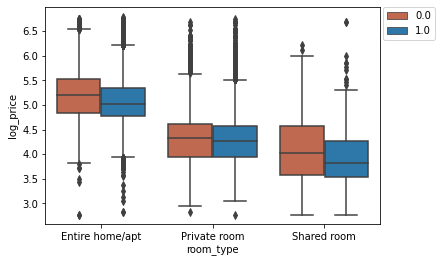

In [36]:
sns.boxplot(data = eda_data, x = 'room_type', y = 'log_price', hue = 'has_reviews', palette = palette)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [37]:
eda_data['neighbourhood_group'].unique()

array(['Brooklyn', 'Queens', 'Manhattan', 'Staten Island', 'Bronx'],
      dtype=object)

<AxesSubplot:xlabel='neighbourhood_group', ylabel='log_price'>

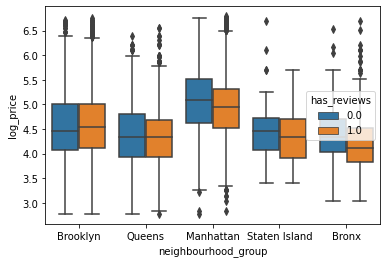

In [38]:
sns.boxplot(data = eda_data, x = 'neighbourhood_group', y = 'log_price', hue = 'has_reviews')

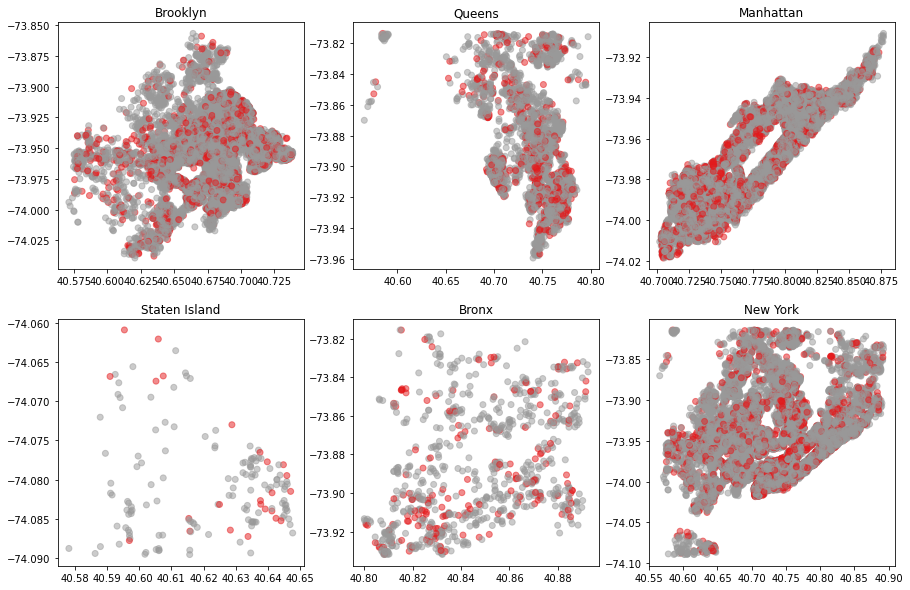

In [39]:
fig, axs = plt.subplots(ncols = 3, nrows =2, figsize = (15,10))

neighs = eda_data['neighbourhood_group'].unique().tolist() + ['New York']
i = 0

for row in range(2):
    for col in range(3):
        if i < 5:
            neigh_dat = eda_data[eda_data['neighbourhood_group']==neighs[i]]
        else:
            neigh_dat = eda_data
        axs[row, col].scatter(x = neigh_dat['latitude'], y = neigh_dat['longitude'], 
                              c = neigh_dat['has_reviews'], alpha = 0.5, cmap = 'Set1')
        axs[row, col].set_title(neighs[i])
        i+=1

It doesn't appear that location has an impact on whether or not a listing has reviews - there is a mixture of both in each neighbourhood and fairly well distributed.

The latitude and longitude will be included anyway, to see if there is a relationship influenced by another factor.

Even though one could argue that entire home is "better" than private room, assigning the room types values 1, 2, and 3 would assume that they are equally spaced. These  values will be one hot encoded instead.
For now, neighbourhood and neighbourhood group will **not** be used - the assumption is that the information about vicinity is adequately encoded by latitude and longitude. They can be brought back in later if needed.



In [40]:
ohe = OneHotEncoder()

def adjust_column_headers(col: str):
    return col.lower().replace(' ', '_')

def one_hot_encode(df, col_to_encode, ohe: OneHotEncoder, fit = True, col_to_drop = None) -> pd.DataFrame:
    data_to_encode = df[[col_to_encode]]
    if fit:
        ohe_data_array = ohe.fit_transform(data_to_encode).toarray()
    else:
        ohe_data_array = ohe.transform(data_to_encode).toarray()
    column_names = ohe.get_feature_names([col_to_encode])
    column_names = [adjust_column_headers(col) for col in column_names]
    col_to_drop = col_to_encode + '_' + adjust_column_headers(col_to_drop)
    ohe_data = pd.DataFrame(data = ohe_data_array, columns = column_names)
    if col_to_drop is None:
        cols_to_drop = [col_to_encode]
    else:
        cols_to_drop = [col_to_encode, col_to_drop]
    new_df = pd.concat([df.reset_index(drop = True), ohe_data], axis = 1).drop(columns = cols_to_drop)
    return new_df
    
eda_data = one_hot_encode(eda_data, 'room_type', ohe, col_to_drop = 'Shared room')
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room
0,Brooklyn,Williamsburg,40.71756,-73.95579,165.0,8.0,1.0,297.0,1.0,5.111988,0.813699,1.0,0.0
1,Brooklyn,Bedford-Stuyvesant,40.68631,-73.92629,200.0,2.0,1.0,0.0,0.0,5.303305,0.000000,0.0,1.0
2,Queens,Astoria,40.76413,-73.92374,98.0,6.0,1.0,306.0,1.0,4.595120,0.838356,1.0,0.0
3,Brooklyn,Bushwick,40.69738,-73.92947,160.0,3.0,1.0,270.0,1.0,5.081404,0.739726,1.0,0.0
4,Manhattan,Midtown,40.74897,-73.98265,500.0,5.0,1.0,0.0,0.0,6.216606,0.000000,0.0,1.0


Before attempting to visualise two or three variables together, the data will be scaled.

In [41]:
def scale_data(df: pd.DataFrame, columns_to_transform: List[str], scaler, fit = True, drop = True) -> pd.DataFrame:
    data_to_transform = df.copy()[columns_to_transform]
    scaled_data = scaler.fit_transform(data_to_transform)
    new_cols = ['scaled_' + col for col in columns_to_transform]
    df[new_cols] = scaled_data
    if drop:
        df.drop(columns=columns_to_transform, inplace = True)
    return df

eda_data_scaled = scale_data(eda_data,['minimum_nights', 'calculated_host_listings_count'], MinMaxScaler(), drop = False)
eda_data_scaled = scale_data(eda_data_scaled, ['longitude', 'latitude', 'price', 'log_price'], StandardScaler(), drop = False)
eda_data_scaled.sample(12)

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_price,scaled_log_price
10742,Brooklyn,Bedford-Stuyvesant,40.68175,-73.93886,135.0,3.0,2.0,134.0,1.0,4.912655,0.367123,1.0,0.0,0.029851,0.009804,0.430511,-0.897269,-0.027978,0.306508
2706,Queens,Long Island City,40.75541,-73.93350,35.0,1.0,9.0,273.0,1.0,3.583519,0.747945,0.0,1.0,0.000000,0.078431,0.577004,0.471148,-0.963044,-1.755555
1218,Manhattan,Inwood,40.86725,-73.92726,150.0,1.0,1.0,16.0,0.0,5.017280,0.043836,1.0,0.0,0.000000,0.000000,0.747548,2.548853,0.112282,0.468827
25826,Brooklyn,East Flatbush,40.65943,-73.91939,110.0,2.0,1.0,2.0,1.0,4.709530,0.005479,1.0,0.0,0.014925,0.000000,0.962641,-1.311918,-0.261744,-0.008626
37313,Brooklyn,Crown Heights,40.67175,-73.92117,46.0,3.0,1.0,19.0,1.0,3.850148,0.052055,0.0,1.0,0.029851,0.000000,0.913992,-1.083043,-0.860187,-1.341899
19309,Brooklyn,Crown Heights,40.67504,-73.93956,50.0,30.0,1.0,113.0,0.0,3.931826,0.309589,0.0,1.0,0.432836,0.000000,0.411380,-1.021923,-0.822784,-1.215181
32308,Brooklyn,Greenpoint,40.72722,-73.95247,100.0,2.0,1.0,284.0,1.0,4.615121,0.778082,0.0,1.0,0.014925,0.000000,0.058540,-0.052551,-0.355251,-0.155096
21749,Brooklyn,Williamsburg,40.70870,-73.95427,70.0,20.0,4.0,275.0,1.0,4.262680,0.753425,0.0,1.0,0.283582,0.029412,0.009345,-0.396606,-0.635771,-0.701883
28653,Brooklyn,Prospect-Lefferts Gardens,40.65473,-73.96112,115.0,2.0,2.0,86.0,1.0,4.753590,0.235616,1.0,0.0,0.014925,0.009804,-0.177871,-1.399232,-0.214991,0.059730
885,Brooklyn,Crown Heights,40.66981,-73.95734,68.0,30.0,7.0,226.0,1.0,4.234107,0.619178,0.0,1.0,0.432836,0.058824,-0.074561,-1.119084,-0.654472,-0.746213


<AxesSubplot:title={'center':'Distribution of scaled calculated host listings count of AirBnB listings in New York City'}, xlabel='Scaled_Calculated_Host_Listings_Count', ylabel='Density'>

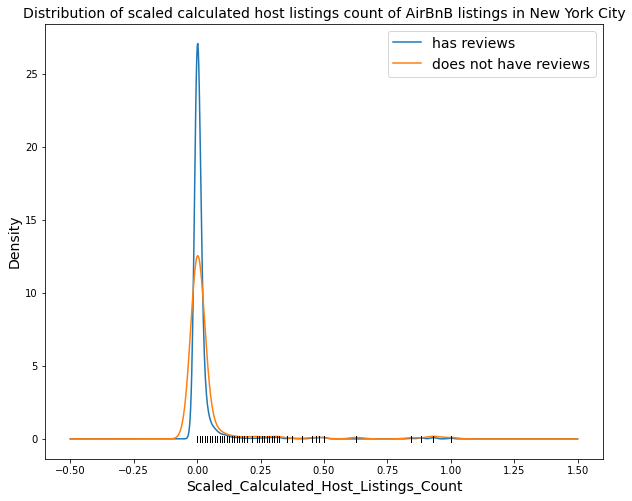

In [42]:
plot_distribution(eda_data_scaled, 'scaled_calculated_host_listings_count')

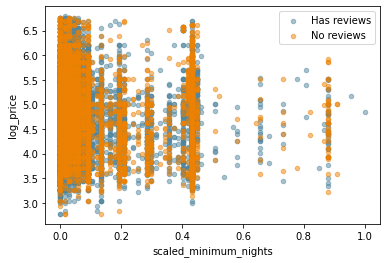

In [43]:
def plot_two_variables(df, var1, var2, color_col = 'has_reviews', label1 = 'Has reviews', label0 = 'No reviews'):
    ax = df[df[color_col]==1].plot(kind = 'scatter', x = var1, y = var2, 
                                  label = label1, color = '#50869D', 
                                  alpha = 0.5)
    df[df[color_col]==0].plot(kind = 'scatter',x = var1, y = var2, 
                                       label = label0, color = '#ED8103',
                                       alpha = 0.5, ax=ax)
    ax.legend()
    return ax;
    
plot_two_variables(eda_data, 'scaled_minimum_nights',  'log_price');

<AxesSubplot:xlabel='scaled_minimum_nights', ylabel='scaled_calculated_host_listings_count'>

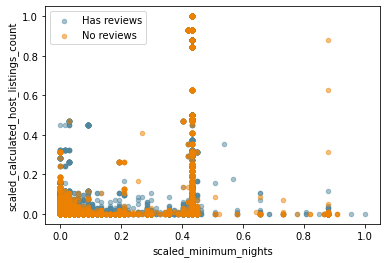

In [44]:
plot_two_variables(eda_data, 'scaled_minimum_nights', 'scaled_calculated_host_listings_count')

<AxesSubplot:xlabel='scaled_minimum_nights', ylabel='availability_frac'>

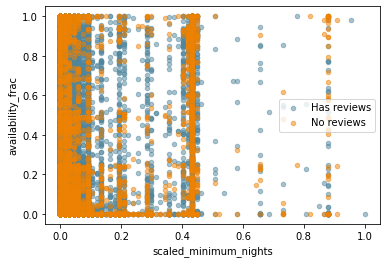

In [45]:
plot_two_variables(eda_data, 'scaled_minimum_nights', 'availability_frac')

sns.pairplot(eda_data[['has_reviews', 'log_price', 'availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude']])

In [46]:
no_reviews = eda_data[eda_data['has_reviews']==0]

prop_unavailable = len(no_reviews[no_reviews['availability_365']==0])/len(no_reviews)

print(f"{prop_unavailable*100: .1f}% of listings without reviews have availability = 0")

 51.5% of listings without reviews have availability = 0


There are a number of measures that have not been taken that will be tested to see if they improve model accuracy after the first round of model training:
   
- downsampling listings with reviews

For now, all of the preprocessing steps above will be repeated on X_train and X_test (transformers will be fit only on X_test).
    

In [47]:
eda_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,has_reviews,log_price,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_price,scaled_log_price
0,Brooklyn,Williamsburg,40.71756,-73.95579,165.0,8.0,1.0,297.0,1.0,5.111988,0.813699,1.0,0.0,0.104478,0.0,-0.032198,-0.232009,0.252542,0.615760
1,Brooklyn,Bedford-Stuyvesant,40.68631,-73.92629,200.0,2.0,1.0,0.0,0.0,5.303305,0.000000,0.0,1.0,0.014925,0.0,0.774059,-0.812555,0.579816,0.912575
2,Queens,Astoria,40.76413,-73.92374,98.0,6.0,1.0,306.0,1.0,4.595120,0.838356,1.0,0.0,0.074627,0.0,0.843752,0.633144,-0.373952,-0.186126
3,Brooklyn,Bushwick,40.69738,-73.92947,160.0,3.0,1.0,270.0,1.0,5.081404,0.739726,1.0,0.0,0.029851,0.0,0.687147,-0.606903,0.205789,0.568311
4,Manhattan,Midtown,40.74897,-73.98265,500.0,5.0,1.0,0.0,0.0,6.216606,0.000000,0.0,1.0,0.059701,0.0,-0.766302,0.351509,3.385016,2.329499


## Apply preprocessing steps to train and test datasets

In [48]:
def convert_availability_column(df):
    new_df = df.copy()
    new_df['availability_frac'] = new_df['availability_365'] / 365
    new_df.drop(columns = ['availability_365'], inplace = True)
    return new_df

def apply_transformations(df,
                          one_hot_encoder, 
                          minmax_scaler, 
                          standard_scaler, 
                          fit = False):
    new_df = convert_availability_column(df)
    log_df = transform_log_normal_variables(new_df, ['price'], drop = True)
    ohe_df = one_hot_encode(log_df, 'room_type', one_hot_encoder, col_to_drop = 'Shared room', fit = fit)
    minmax_scaled_df = scale_data(ohe_df, ['minimum_nights', 'calculated_host_listings_count'], 
                                  minmax_scaler, drop = True, fit = fit)
    standard_scaled_df = scale_data(minmax_scaled_df, ['longitude', 'latitude', 'log_price'],
                                   standard_scaler, drop = True, fit = fit)
    return standard_scaled_df

one_hot_encoder = OneHotEncoder()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
outlier_remover = OutlierRemover()

proc_train = apply_transformations(raw_train,
                                   one_hot_encoder,
                                   minmax_scaler,
                                   standard_scaler,
                                   fit = True)
proc_test = apply_transformations(raw_test,
                                  one_hot_encoder,
                                  minmax_scaler,
                                  standard_scaler,
                                  fit = False)
proc_train.head()

,neighbourhood_group,neighbourhood,has_reviews,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
0,Brooklyn,Williamsburg,1,0.813699,1.0,0.0,0.005604,0.0,-0.079458,-0.211645,0.540929
1,Brooklyn,Bedford-Stuyvesant,0,0.000000,0.0,1.0,0.000801,0.0,0.560400,-0.784622,0.817611
2,Queens,Astoria,1,0.838356,1.0,0.0,0.004003,0.0,0.615710,0.642227,-0.206565
3,Brooklyn,Bushwick,1,0.739726,1.0,0.0,0.001601,0.0,0.491425,-0.581651,0.496699
4,Manhattan,Midtown,0,0.000000,0.0,1.0,0.003203,0.0,-0.662054,0.364265,2.138426


In [49]:
proc_train.describe()

,has_reviews,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
count,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000,39595.000000,3.959500e+04,3.959500e+04,3.959500e+04
mean,0.795959,0.309867,0.519485,0.457103,0.004850,0.018929,2.198819e-14,-7.097335e-14,-3.561770e-16
std,0.403004,0.360660,0.499627,0.498163,0.016624,0.101216,1.000013e+00,1.000013e+00,1.000013e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.339869e+00,-4.204511e+00,-3.384188e+00
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.712720e-01,-7.142143e-01,-7.078532e-01
50%,1.000000,0.123288,1.000000,0.000000,0.001601,0.000000,-7.663814e-02,-1.064010e-01,-1.077619e-01
75%,1.000000,0.624658,1.000000,1.000000,0.003203,0.003067,3.438243e-01,6.256336e-01,6.255258e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.186896e+00,3.372895e+00,6.468106e+00


## Feature Selection

For now, we will ignore the neighbourhoods and neighbourhood groups assuming that the longitude and latitude information is enough for listings in the same neighbourhood to be considered similar.

This leaves us with the following columns:

In [50]:
cols_to_drop = ['neighbourhood_group', 'neighbourhood']

# save for later
neighbourhood_info_tr = proc_train[cols_to_drop]
neighbourhood_info_ts = proc_test[cols_to_drop]

proc_train.drop(columns = cols_to_drop, inplace = True)
proc_test.drop(columns = cols_to_drop, inplace = True)
proc_train.columns

Index(['has_reviews', 'availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude', 'scaled_log_price'],
      dtype='object')

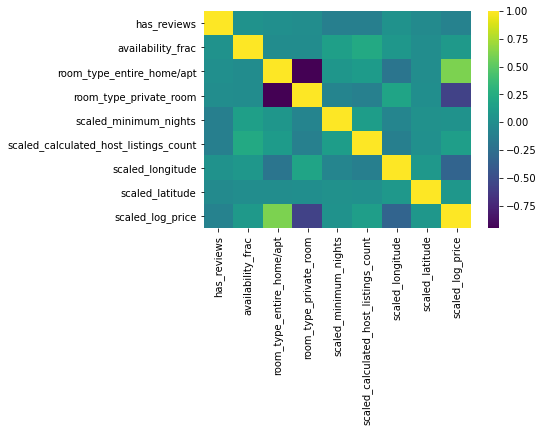

In [51]:
corrMatrix = proc_train.corr()
sns.heatmap(corrMatrix, cmap = 'viridis');

In [52]:
len(proc_train[proc_train['availability_frac']==0])/len(proc_train)

0.3571410531632782

In [53]:
y_train = proc_train.pop('has_reviews')
X_train = proc_train.copy()

y_test = proc_test.pop('has_reviews')
X_test = proc_test.copy()

In [54]:
# Convert X_train, X_test, y_train, and y_test to numpy

X_train_np, X_test_np, y_train_np, y_test_np =  [df.to_numpy() for df in [X_train, X_test, y_train, y_test]]

y_train_np.shape

(39595,)

## Statistical Analysis

### Evaluation metric

How choose appropriate evaluation metric.

F1 score - balances precision and recall. Use f1 score of the *negative* class because it is more important to accurately identify poor performers than good performers.

We want to balance recall (catching as many of the real "no review" listings as possible) with precision (not calling out listings for not getting reviews when actually they will). 

### Model comparison

I'm gonna compare three model types: logistic regression and decision tree which are both relatively easy to explain using coefficient and leaf splits, and XGboost classifier which balances explainability with accuracy (CITE ME PLEASE).

To make the comparison the f1 score on the important (negative) class will be saved for comparison.

In [55]:
results_loc = 'model_comparison.csv'

with open(results_loc, 'w', newline = '') as f:
    writer = csv.writer(f)
    writer.writerow(['model_name', 'number_of_features', 'downsampled_data', 'outliers_removed', 'f1_negative_class', 'f1_macro_average'])

def calculate_f1s(y_pred, y_test):
    f1_negative_class = f1_score(y_test, y_pred, pos_label = 0)
    f1_macro_average = f1_score(y_test, y_pred, average = 'macro')
    return f1_negative_class, f1_macro_average   
    
def record_score(filename, model_name, num_features, downsampled, outliers_removed, y_pred, y_test):
    with open(filename, 'a', newline = '') as f:
        writer = csv.writer(f)
        row = [model_name, num_features]
        if downsampled:
            row.append('y')
        else:
            row.append('n')
        if outliers_removed:
            row.append('y')
        else:
            row.append('n')
        row += calculate_f1s(y_pred, y_test)
        writer.writerow(row)

## Logistic Regression


F1 scores for  Logistic Regression :

F1 score of negative class: 	 0.38683431952662717 
Macro average F1 score: 	 0.5574263461150196


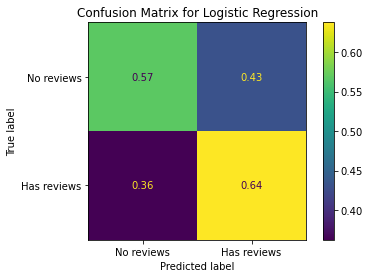

In [56]:
lr = LogisticRegression(C = 1, class_weight = 'balanced')

lr.fit(X_train_np, y_train_np)

def evaluate_model(model, X_test, y_test, model_name: str):
    target_names = []
    for y in y_test:
        if y == 0:
            target_names.append("No reviews")
        else:
            target_names.append("Has reviews")
        if len(target_names)==2:
            break
    y_pred = model.predict(X_test)
    f1_negative_class, f1_macro_average = calculate_f1s(y_pred, y_test)
    print("F1 scores for ", model_name, ":\n")
    print("F1 score of negative class: \t", f1_negative_class,
         "\nMacro average F1 score: \t", f1_macro_average)
    ax = plot_confusion_matrix(model, 
                      X_test, 
                      y_test, 
                      normalize = 'true', 
                      display_labels = ['No reviews', 'Has reviews'])
    plt.title("Confusion Matrix for " + model_name);
    return y_pred

y_pred = evaluate_model(lr, X_test_np, y_test_np, "Logistic Regression");

record_score(results_loc,
             "Logistic Regression", X_train_np.shape[1],
             False, False, y_pred, y_test)

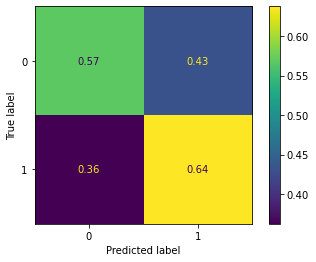

In [57]:
plot_confusion_matrix(lr, X_test_np, y_test_np, normalize = 'true')

In [58]:
y_test[:10]

0    0
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: has_reviews, dtype: int64

In [59]:
classif_report = classification_report(y_test_np, y_pred, target_names=["No reviews", "Has reviews"])
print(classif_report)

              precision    recall  f1-score   support

  No reviews       0.29      0.57      0.39       920
 Has reviews       0.85      0.64      0.73      3480

    accuracy                           0.62      4400
   macro avg       0.57      0.60      0.56      4400
weighted avg       0.73      0.62      0.66      4400



## Decision Tree

F1 scores for  Decision Tree :

F1 score of negative class: 	 0.3667532467532467 
Macro average F1 score: 	 0.5947220779220779


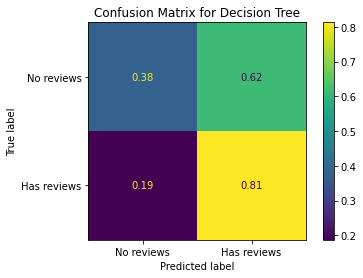

In [60]:
tree = DecisionTreeClassifier()

tree.fit(X_train_np, y_train_np)

y_pred = evaluate_model(DecisionTreeClassifier().fit(X_train_np, y_train_np), X_test_np, y_test_np, "Decision Tree")

record_score(results_loc,
             "Decision Tree", X_train_np.shape[1],
             False, False, y_pred, y_test)

It seems that the imbalance in class labels is causing the models to perform poorly. XGBoost has a `scale_pos_weight` parameter that may give it an advantage, but we can also try using `sklearn`'s `resample` to downsample the listings that have reviews, to see if it improves model performance. 

We can also test a random forest classifier that allows for class weights.

F1 scores for  Random Forest :

F1 score of negative class: 	 0.4667876588021779 
Macro average F1 score: 	 0.6118884530570029


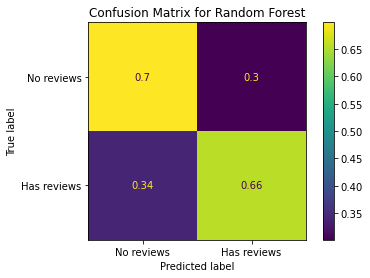

In [61]:
r_f = RandomForestClassifier(n_estimators = 100, max_depth = 6, class_weight = 'balanced', random_state = 42)

r_f.fit(X_train_np, y_train_np)

y_pred = evaluate_model(r_f, X_test_np, y_test_np, "Random Forest")

record_score(results_loc,
             "Random Forest", X_train_np.shape[1],
             False, False, y_pred, y_test)

### Using XGBoost's `scale_pos_weight`

Using the scale_pos_weight parameter to adjust for imbalanced classes (see [this](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/#:~:text=The%20XGBoost%20algorithm%20is%20effective,over%20the%20model%20training%20procedure.) blog post).


In [62]:
prop_no_reviews = sum(y_train==0)/sum(y_train==1)
prop_no_reviews

0.25634598299276556

F1 scores for  XGBoost :

F1 score of negative class: 	 0.47536945812807874 
Macro average F1 score: 	 0.6372761809810727


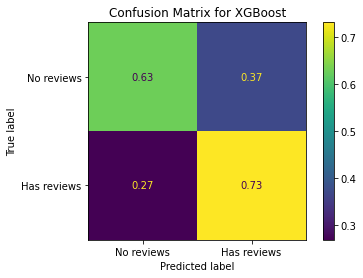

In [63]:
xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', scale_pos_weight = prop_no_reviews, seed = 42)

xgb_model.fit(X_train_np, y_train_np)

y_pred = evaluate_model(xgb_model, X_test_np, y_test_np, "XGBoost")

record_score(results_loc,
             "XGBoost", X_train_np.shape[1],
             False, False, y_pred, y_test_np)

### Downsampling

In [64]:
# we will downsample only the training data.

def downsample(df: pd.DataFrame, target_col: str, majority_label: int) -> pd.DataFrame:
    minority_label = 1 if majority_label == 0 else 0
    # separate majority and minority class
    majority_class = df[df[target_col]== majority_label]
    minority_class = df[df[target_col]== minority_label]
    # count number of observations in minority class
    count_minority_class = len(minority_class.index)
    majority_class_downsampled = resample(majority_class, replace = False, n_samples = count_minority_class, random_state = 42)
    df_balanced = pd.concat([majority_class_downsampled, minority_class], axis = 0, sort = True)
    df_balanced.reset_index(drop=True)
    return df_balanced
    
# reattach target variable
proc_train['has_reviews'] = y_train

downsample_demo = proc_train.copy().reset_index()

train_ds = downsample(proc_train, 'has_reviews', 1)

print(train_ds["has_reviews"].value_counts())

y_train_ds = train_ds.pop('has_reviews')
X_train_ds = train_ds

0    8079
1    8079
Name: has_reviews, dtype: int64


In [65]:
# Make sure columns are still in same order
X_train_ds = X_train_ds[X_test.columns]
X_train_ds.columns

Index(['availability_frac', 'room_type_entire_home/apt',
       'room_type_private_room', 'scaled_minimum_nights',
       'scaled_calculated_host_listings_count', 'scaled_longitude',
       'scaled_latitude', 'scaled_log_price'],
      dtype='object')

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


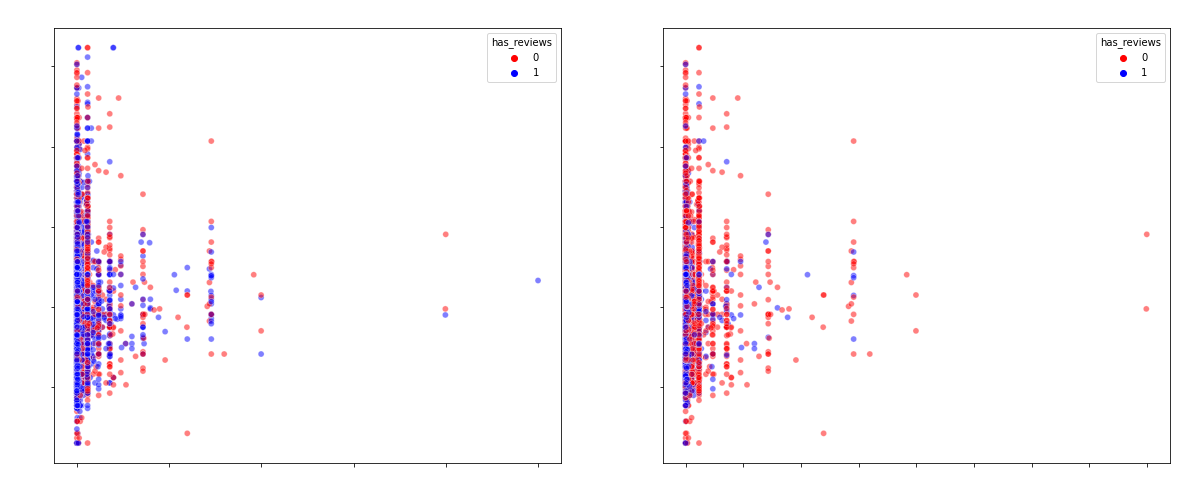

In [66]:
## visualise the downsampling

downsample_demo['in_downsampled_dataset'] = downsample_demo['index'].apply(lambda i: i in train_ds.index)
categories = [
    (downsample_demo['has_reviews']==1) & (downsample_demo['in_downsampled_dataset']),
    (downsample_demo['has_reviews']==0) & (downsample_demo['in_downsampled_dataset']),
    (~downsample_demo['in_downsampled_dataset'])
]
category_labels = [
    'Has reviews', 'No reviews', 'Removed from dataset'
]

downsample_demo['category'] = np.select(categories, category_labels)

palette = {
    1: 'blue', 
    0: 'red'
}

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20,8))
sns.scatterplot(data = downsample_demo,
                x = 'scaled_minimum_nights',
                y = 'scaled_log_price',
                hue = 'has_reviews',
                alpha = 0.5,
                palette = palette,
                ax = ax1)
ax1.set_title("Before downsampling", fontsize = 20, color = 'white')
ax1.set_xlabel("Scaled minimum nights", fontsize = 16, color = 'white')
ax1.set_ylabel("Scaled log price", fontsize = 16, color = 'white')
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize = 14, color = 'white')

sns.scatterplot(data = downsample_demo[downsample_demo['category']!='Removed from dataset'],
                x = 'scaled_minimum_nights',
                y = 'scaled_log_price',
                hue = 'has_reviews',
                alpha = 0.5,
                palette = palette,
                ax = ax2)

ax2.set_title("After downsampling", fontsize = 20, color = 'white')
ax2.set_xlabel("Scaled minimum nights", fontsize = 16, color = 'white')
ax2.set_ylabel("Scaled log price", fontsize = 16, color = 'white')
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize = 14, color = 'white')

plt.draw()

ax1.set_yticklabels(ax1.get_yticklabels(), fontsize = 14, color = 'white')
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize = 14, color = 'white');

F1 scores for  Logistic Regression :

F1 score of negative class: 	 0.380134428678118 
Macro average F1 score: 	 0.5544906053877359


,feature,coef
3,scaled_minimum_nights,-9.775797
4,scaled_calculated_host_listings_count,-3.059861
1,room_type_entire_home/apt,1.080192
0,availability_frac,0.634487
2,room_type_private_room,0.460691
7,scaled_log_price,-0.377558
6,scaled_latitude,-0.038771
5,scaled_longitude,0.002803


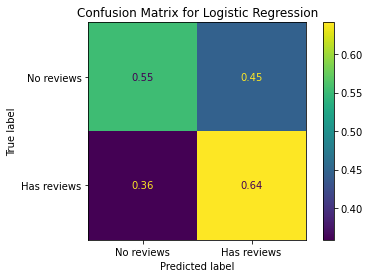

In [67]:
lr = LogisticRegression()

lr.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(lr, X_test, y_test, "Logistic Regression")

record_score(results_loc,
             "Logistic Regression", X_train_ds.shape[1],
             True, False, y_pred, y_test)

coefficients = pd.DataFrame(data = {
    'feature': X_train_ds.columns,
    'coef': lr.coef_[0],
    'coef_magnitude': [abs(c) for c in lr.coef_[0]]
})
coefficients.sort_values('coef_magnitude', ascending = False).drop(columns = ['coef_magnitude'])

In [68]:
print("Size of original dataset: ", len(X_train),
      "\nSize of downsampled dataset: ", len(X_train_ds),
     "\nSize of test dataset: ", len(X_test))

Size of original dataset:  39595 
Size of downsampled dataset:  16158 
Size of test dataset:  4400


,num_features,neg_class_f1
0,1,0.197874
1,2,0.283433
2,3,0.335104
3,4,0.332659
4,5,0.336808
5,6,0.368739
6,7,0.383167


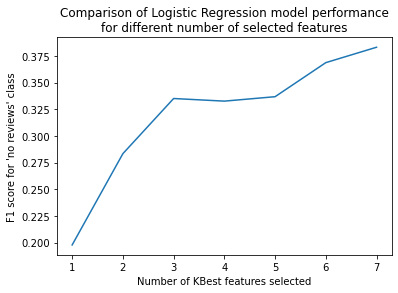

In [69]:
# Choose the best number of features

def feature_select(X_train, y_train, X_test, y_test, model, model_name):
    num_features = range(1,len(X_train.columns))
    f1_scores = []

    for num in num_features:
        kbest = SelectKBest(score_func = f_classif, k = num)
        kbest.fit(X=X_train, y = y_train)

        selected_columns = X_train.columns[kbest.get_support()]

        model.fit(X_train[selected_columns], y_train)
        y_pred = model.predict(X_test[selected_columns])

        # look specifically at the F1 score of the 'no reviews' class
        f1 = f1_score(y_test, y_pred, pos_label = 0)
        #print("Number of features: ", num, "\t\tNegative class F1 score: ", f1)
        f1_scores.append(f1)
    ax = plt.plot(num_features, f1_scores)
    plt.ylabel("F1 score for 'no reviews' class")
    plt.xlabel("Number of KBest features selected")
    plt.title(f"Comparison of {model_name} model performance\nfor different number of selected features")
    return pd.DataFrame(data = {'num_features': num_features, 'neg_class_f1': f1_scores})
    
feature_select(X_train_ds, y_train_ds, X_test, y_test, LogisticRegression(), "Logistic Regression")

The model actually appears to perform the best with all of the features.

In [70]:
def get_coefficients(X_test, model):
    coefs = model.coef_[0]
    coefficients = pd.DataFrame(data = {
            'feature': X_test.columns,
            'coef': coefs,
            'coef_magnitude': [abs(c) for c in coefs]
        })

    return coefficients.sort_values('coef_magnitude', ascending = False).drop(columns = ['coef_magnitude'])

get_coefficients(X_test, lr)

,feature,coef
3,scaled_minimum_nights,-9.775797
4,scaled_calculated_host_listings_count,-3.059861
1,room_type_entire_home/apt,1.080192
0,availability_frac,0.634487
2,room_type_private_room,0.460691
7,scaled_log_price,-0.377558
6,scaled_latitude,-0.038771
5,scaled_longitude,0.002803


Let's test our new downsampled dataset with a decision tree.

#### Decision Tree

F1 scores for  Decision Tree :

F1 score of negative class: 	 0.40264255910987484 
Macro average F1 score: 	 0.5563179034577058


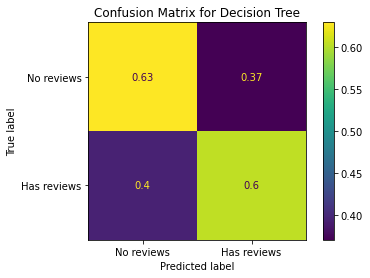

In [71]:
tree = DecisionTreeClassifier()

tree.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(tree, X_test, y_test, "Decision Tree")

record_score(results_loc,
             "Decision Tree", X_train_ds.shape[1],
             True, False, y_pred, y_test)

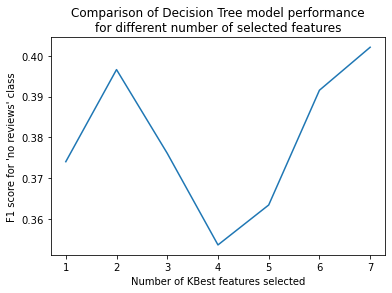

In [72]:
feature_select(X_train_ds, y_train_ds, X_test, y_test, tree, "Decision Tree");

F1 scores for  Decision Tree :

F1 score of negative class: 	 0.3966303966303966 
Macro average F1 score: 	 0.5538856906694244


'Selected features: scaled_minimum_nights, scaled_calculated_host_listings_count'

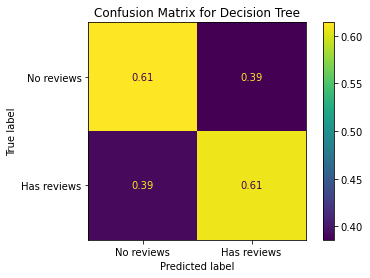

In [73]:
def get_selected_columns(X_train, y_train, k):
    kbest = SelectKBest(score_func = f_classif, k = k)
    kbest.fit(X=X_train, y = y_train)
    cols = kbest.get_support()
    selected_cols = X_train.columns[cols]
    return selected_cols

selected_features = get_selected_columns(X_train_ds, y_train_ds, 2)

tree.fit(X_train_ds[selected_features], y_train_ds)

y_pred = evaluate_model(tree, X_test[selected_features], y_test, "Decision Tree")

record_score(results_loc,
             "Decision Tree", len(selected_features),
             True, False, y_pred, y_test)

'Selected features: ' + ', '.join(selected_features)

F1 scores for  Random Forest :

F1 score of negative class: 	 0.47020348837209297 
Macro average F1 score: 	 0.6145660299003322


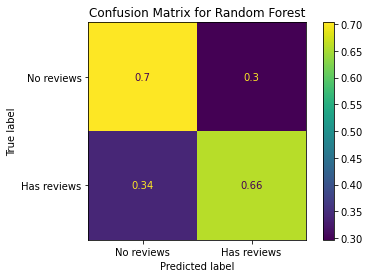

In [74]:
r_f = RandomForestClassifier(n_estimators = 100, max_depth = 6, class_weight = 'balanced')

r_f.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(r_f, X_test, y_test, "Random Forest")

record_score(results_loc,
             "Random Forest", X_train_ds.shape[1],
             True, False, y_pred, y_test)

#### XGBoost

F1 scores for  XGBoost with downsampling :

F1 score of negative class: 	 0.4842951059167276 
Macro average F1 score: 	 0.6256843394974598


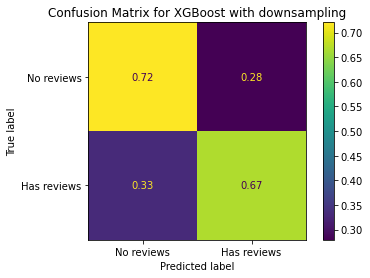

In [75]:
xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', seed = 42)

xgb_model.fit(X_train_ds, y_train_ds)

y_pred = evaluate_model(xgb_model, X_test, y_test, "XGBoost with downsampling")

record_score(results_loc,
             "XGBoost", X_train_ds.shape[1],
             True, False, y_pred, y_test)

,num_features,neg_class_f1
0,1,0.374062
1,2,0.402235
2,3,0.419575
3,4,0.424197
4,5,0.416729
5,6,0.465884
6,7,0.475046


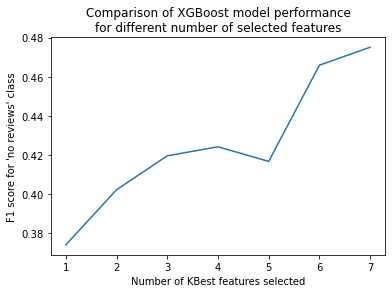

In [76]:
feature_select(X_train_ds, y_train_ds, X_test, y_test, xgb_model, "XGBoost")

### Re-testing with outlier removal

In [77]:
numeric_columns = X_train.select_dtypes('number').columns

# fit the outlier remover to the full (not downsampled) training set

o_r = OutlierRemover()
o_r.fit(proc_train[numeric_columns])

# remove the outliers from each of the downsampled and not downsampled datasets.

X_train_ds_ol = pd.concat([X_train_ds, y_train_ds], axis = 1)
X_train_ol = pd.concat([X_train, y_train], axis = 1)

# Separate target variable in test dataset
X_train_ds_ol = o_r.transform(X_train_ds_ol)
X_train_ol = o_r.transform(X_train_ol)

y_train_ds_ol = X_train_ds_ol.pop('has_reviews')
y_train_ol = X_train_ol.pop('has_reviews')

print("Size of original dataset: ", len(X_train),
      "\nSize of dataset without outliers: ", len(X_train_ol),
      "\nSize of downsampled dataset: ", len(X_train_ds),
      "\nSize of downsampled dataset without outliers: ", len(X_train_ds_ol),
     "\n\nSize of test dataset: ", len(X_test),
     "\n\nProportion of listings with reviews in downsampled training dataset: ", len(y_train_ds_ol[y_train_ds_ol==1])/len(y_train_ds_ol[y_train_ds_ol==0]),
     "\n\nProportion of listings with reviews in training dataset: ", len(y_train_ol[y_train_ol==1])/len(y_train_ol[y_train_ol==0]),)

Size of original dataset:  39595 
Size of dataset without outliers:  37473 
Size of downsampled dataset:  16158 
Size of downsampled dataset without outliers:  15052 

Size of test dataset:  4400 

Proportion of listings with reviews in downsampled training dataset:  1.0568461328231757 

Proportion of listings with reviews in training dataset:  4.1206613828915


In [78]:
downsampled = False

for model, model_name in zip([lr, tree, xgb_model, r_f], ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Random Forest']):
    for training_set in [(X_train_ol, y_train_ol), (X_train_ds_ol, y_train_ds_ol)]:
        model.fit(training_set[0], training_set[1])
        y_pred = model.predict(X_test)
        record_score(results_loc,
                 model_name, training_set[0].shape[1],
                 downsampled, True, y_pred, y_test)
        downsampled = not downsampled

In [79]:
all_models = pd.read_csv(results_loc).drop_duplicates() # in case cell was run twice
all_models.sort_values('f1_negative_class', ascending = False)

,model_name,number_of_features,downsampled_data,outliers_removed,f1_negative_class,f1_macro_average
8,XGBoost,8,y,n,0.484295,0.625684
3,XGBoost,8,n,n,0.475369,0.637276
14,XGBoost,8,y,y,0.474466,0.617097
7,Random Forest,8,y,n,0.470203,0.614566
2,Random Forest,8,n,n,0.466788,0.611888
15,Random Forest,8,n,y,0.465608,0.605813
16,Random Forest,8,y,y,0.460961,0.595744
12,Decision Tree,8,y,y,0.405638,0.556070
5,Decision Tree,8,y,n,0.402643,0.556318
6,Decision Tree,2,y,n,0.396630,0.553886


FixedFormatter should only be used together with FixedLocator


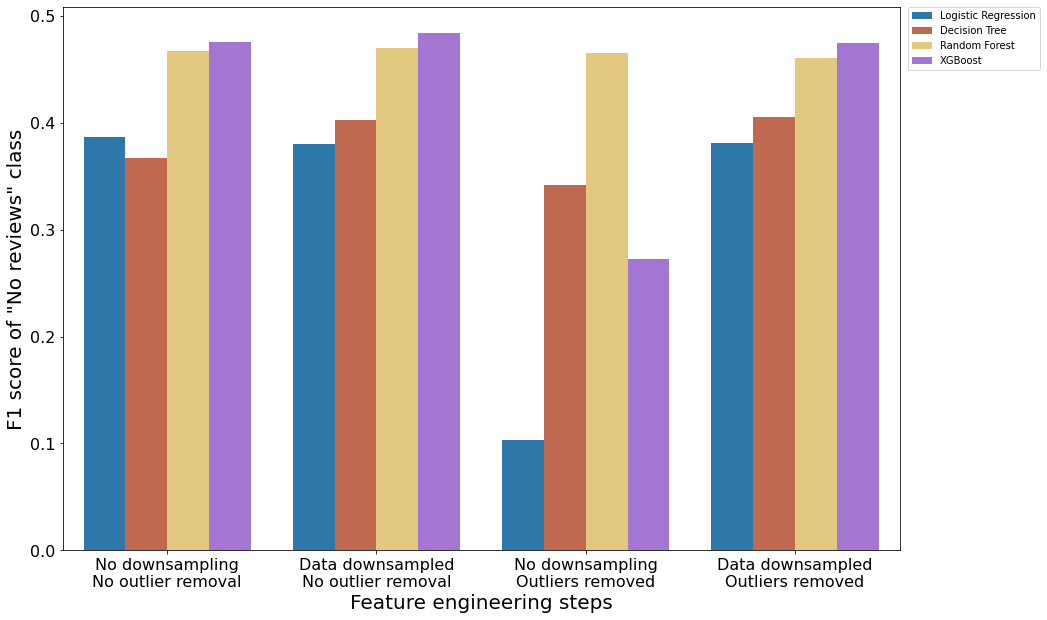

In [80]:
all_models['feature_engineering_steps'] = (all_models['downsampled_data']+all_models['outliers_removed']).map(
    {'nn': 'No downsampling\nNo outlier removal',
     'ny': 'No downsampling\nOutliers removed',
     'yn': 'Data downsampled\nNo outlier removal',
     'yy': 'Data downsampled\nOutliers removed'}
)

model_palette = {
    m: c for m, c in zip(all_models['model_name'].unique().tolist(), ['#197BBD', '#D1603D', '#F4D06F', '#A367E0'])
}

fig, ax = plt.subplots(figsize = (15,10))
sns.barplot(data = all_models[all_models['number_of_features']==8],
            x = 'feature_engineering_steps', y = 'f1_negative_class', hue = 'model_name',
            palette = model_palette);
ax.set_xlabel('Feature engineering steps', fontsize = 20)
ax.set_ylabel('F1 score of "No reviews" class', fontsize = 20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 16)
plt.draw()
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 16)
ax.legend(fontsize = 15)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0);

Interesting that all three models perform better then outlier removal *and* downsampling have been applied than when only outlier removal has been applied. 

### Model Selection

By far the best-performing model was the XGBoost, and the F1 score for the no reviews class was particularly high when the full dataset was used. 

F1 scores for  XGBoost :

F1 score of negative class: 	 0.47536945812807874 
Macro average F1 score: 	 0.6372761809810727


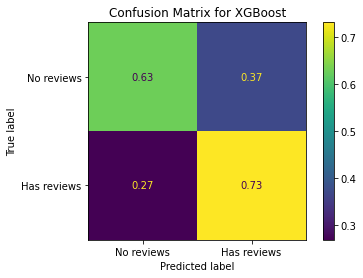

In [81]:
xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', scale_pos_weight = prop_no_reviews, seed = 42)

xgb_model.fit(X_train_np, y_train_np)

y_pred = evaluate_model(xgb_model, X_test_np, y_test_np, "XGBoost");


This model performs much better than all of the previous models, so will be selected for further tuning. The coefficients of the logistic regression model will also be examined, to understand what factors contributed to the predictions.

## Model Tuning

To tune the model we will train it on the training and validation sets and evaluate it against the final test set.

In [82]:
all_training_data = pd.concat([raw_train, raw_test])

y_train_all = all_training_data['has_reviews']

In [83]:
# Fit the transformers to the training dataset
X_train_all = apply_transformations(
    all_training_data.drop(['neighbourhood_group', 'neighbourhood', 'has_reviews'], axis = 1),
    one_hot_encoder, minmax_scaler, standard_scaler, fit = True
)

# prepare the final test set
final_test_set = encode_target(final_test_set)
y_test_final = final_test_set.pop('has_reviews')

X_test_final = apply_transformations(
    final_test_set.drop(['neighbourhood', 'neighbourhood_group'], axis = 1), 
    one_hot_encoder, minmax_scaler, standard_scaler, fit = False
)

X_test_final.shape

(4889, 8)

In [84]:
y_test_final.shape

(4889,)

F1 scores for  Optimised XGBoost Model :

F1 score of negative class: 	 0.4448608137044968 
Macro average F1 score: 	 0.5507984968886602


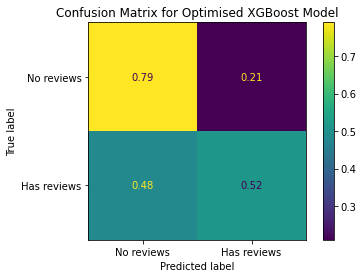

In [85]:
# Warning! GridSearchCV in use, this cell takes a long time to run!

params = {
    'max_depth': [2,4,6,8],
    'learning_rate': [0.1,0.2,0.4,0.8],
    'objective': ['reg:squarederror', 'binary:logistic'],
    'tree_method': ['exact', 'hist']
}

custom_scorer = make_scorer(f1_score, pos_label = 0)

xgb_optimised = GridSearchCV(xgb_model, params, scoring = custom_scorer).fit(X_train_all, y_train_all)

evaluate_model(xgb_optimised, X_test_final, y_test_final, "Optimised XGBoost Model");

When we train the model on the entire training dataset we achieve only a slight improvement on the previous model.

In [86]:
model_parameters = xgb_optimised.best_params_
model_parameters

{'learning_rate': 0.1,
 'max_depth': 6,
 'objective': 'binary:logistic',
 'tree_method': 'hist'}

In [87]:
# fit the model using the best parameters.

model = XGBClassifier(
    use_label_encoder = False, 
    eval_metric = 'logloss', 
    scale_pos_weight = prop_no_reviews, 
    seed = 42,
    tree_method = 'hist'
)
model.set_params(**xgb_optimised.best_params_)
model.fit(X_train_all, y_train_all);

y_pred = model.predict(X_test_final)

### Feature Importance



Something something select K Best. Also let's look at the coefficients of the logistic regression model.

In [88]:

lr.fit(X_train_np, y_train_np)
lr_coefs = get_coefficients(X_test, lr)
lr_coefs

,feature,coef
3,scaled_minimum_nights,-11.378195
4,scaled_calculated_host_listings_count,-2.361291
1,room_type_entire_home/apt,1.238042
0,availability_frac,0.640707
2,room_type_private_room,0.621020
7,scaled_log_price,-0.381664
6,scaled_latitude,-0.036747
5,scaled_longitude,-0.012300


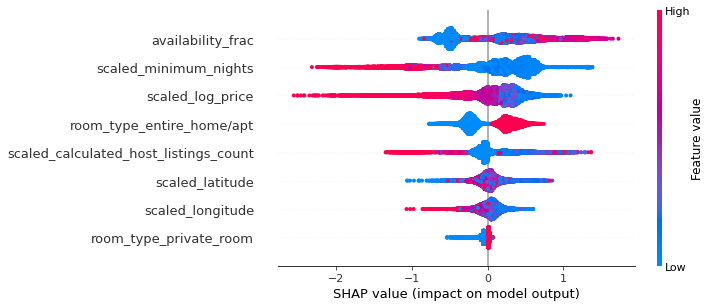

In [89]:
shap_values = shap.TreeExplainer(model).shap_values(X_train_all) 
shap.summary_plot(shap_values, X_train_all)

In [90]:
shap_values.shape

(43995, 8)

A note about the entire home/private room variables. It's likely that the underlying effect is that shared rooms don't tend to get reviews.

### Exploring Results


In [91]:
final_test_set.sort_index()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,1,0
49,Brooklyn,Fort Greene,40.69142,-73.97376,Private room,80,3,2,192
61,Manhattan,Chelsea,40.74623,-73.99530,Entire home/apt,375,180,1,180
62,Manhattan,Upper East Side,40.77065,-73.95269,Entire home/apt,250,2,2,231
71,Manhattan,East Village,40.72162,-73.98008,Entire home/apt,230,9,1,116
...,...,...,...,...,...,...,...,...,...
48849,Manhattan,Harlem,40.80951,-73.95347,Entire home/apt,65,1,1,32
48852,Brooklyn,Bushwick,40.69805,-73.92801,Private room,30,1,1,1
48854,Brooklyn,Greenpoint,40.72781,-73.94947,Private room,150,4,1,267
48862,Brooklyn,Bushwick,40.69308,-73.91025,Private room,130,1,1,83


In [92]:
# for visualising performance, the final test set will be used.

results = final_test_set.reset_index(drop = True).copy()

results_processed = apply_transformations(
    results.drop([
        'neighbourhood_group', 'neighbourhood'
    ], axis = 1),
    one_hot_encoder, minmax_scaler, standard_scaler, fit = False
)

results['y'] = y_test_final.reset_index(drop = True)
results['y_pred'] = model.predict(results_processed)

results.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,y,y_pred
0,Manhattan,Chelsea,40.73778,-73.99616,Private room,99,12,4,29,1,1
1,Manhattan,East Harlem,40.79142,-73.94664,Private room,90,2,4,237,1,1
2,Brooklyn,Williamsburg,40.71906,-73.94394,Entire home/apt,80,30,8,97,1,1
3,Manhattan,Washington Heights,40.84590,-73.94219,Private room,60,1,1,0,1,0
4,Manhattan,Harlem,40.81249,-73.94175,Private room,90,4,2,365,0,0


In [150]:
# for visualising predictions the entire dataset will be used.

results_all = pd.read_csv(path_to_dataset).drop(['last_review', 'reviews_per_month', 'name', 'host_name', 'id'], axis = 1)

results_all = encode_target(results_all)

results_all.rename(columns = {'has_reviews': 'y'}, inplace = True)

for_prediction = apply_transformations(
    results_all.drop(['host_id', 'neighbourhood_group', 'neighbourhood', 'y'], axis = 1),
    one_hot_encoder, minmax_scaler, standard_scaler
)

results_all['y_pred'] = model.predict(for_prediction)

In [94]:
def grouped_f1_scores(df, column):
    groups = df[column].unique()
    f1_scores = []
    num_listings = []
    no_reviews_prop = []
    for group in groups:
        temp = df[df[column]==group]
        f1_scores.append(round(f1_score(temp['y'], temp['y_pred'], pos_label = 0, zero_division = 0),2))
        group_size = len(temp)
        num_listings.append(group_size)
        no_reviews_prop.append(len(temp[temp['y']==0])/group_size)
    return pd.DataFrame(data = {
        column: groups,
        'f1_score': f1_scores,
        'size_of_group': num_listings,
        'prop_without_reviews': no_reviews_prop
    }).sort_values('f1_score', ascending = False).reset_index(drop = True)

f1_scores_room_type = grouped_f1_scores(results, 'room_type')
f1_scores_room_type

,room_type,f1_score,size_of_group,prop_without_reviews
0,Shared room,0.57,116,0.275862
1,Private room,0.45,2256,0.214539
2,Entire home/apt,0.43,2517,0.212952


In [95]:
f1_scores_neighbourhood_group = grouped_f1_scores(results, 'neighbourhood_group')
f1_scores_neighbourhood_group

,neighbourhood_group,f1_score,size_of_group,prop_without_reviews
0,Bronx,0.49,116,0.163793
1,Manhattan,0.48,2126,0.236595
2,Queens,0.45,583,0.204117
3,Brooklyn,0.41,2020,0.200990
4,Staten Island,0.36,44,0.113636


Interestingly the model performs the best on Bronx, where the proportion of listings without reviews is relatively low.

F1 scores for  Final Model for Bronx Only :

F1 score of negative class: 	 0.33644859813084116 
Macro average F1 score: 	 0.38422429906542055


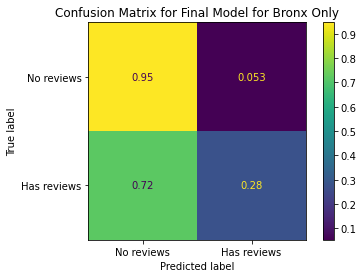

In [96]:
bronx = results[results['neighbourhood_group']=='Bronx']

bronx_processed = apply_transformations(
   bronx.drop([
        'neighbourhood_group', 'neighbourhood', 'y', 'y_pred'
    ], axis = 1),
    one_hot_encoder, minmax_scaler, standard_scaler, fit = False
)

evaluate_model(model, bronx_processed, bronx['y'], "Final Model for Bronx Only");

Despite having a very high f1 score, in this area the model is predicting that almost every listing does not have reviews.

In [97]:
f1_scores_neighbourhood = grouped_f1_scores(results, 'neighbourhood')

f1_scores_neighbourhood.sort_values('size_of_group', ascending = False).head()

,neighbourhood,f1_score,size_of_group,prop_without_reviews
75,Williamsburg,0.39,381,0.217848
76,Bedford-Stuyvesant,0.38,375,0.181333
80,Harlem,0.35,264,0.155303
54,Bushwick,0.46,264,0.265152
51,East Village,0.49,187,0.213904


In [98]:
def group_prop_no_reviews(df, column, predicted = True):
    keep = 'y_pred' if predicted else 'y'
    new_df = df.groupby(column)[[keep]].sum()
    size_of_group = df.groupby(column)[[keep]].count()
    new_df['group_size'] = size_of_group[keep]
    new_df['prop_no_reviews'] = 1 - (new_df[keep]/new_df['group_size'])
    return new_df.reset_index(drop = False).drop([keep], axis = 1)

neighbourhood_props = group_prop_no_reviews(results_all, 'neighbourhood')
neighbourhood_props

,neighbourhood,group_size,prop_no_reviews
0,Allerton,42,0.119048
1,Arden Heights,4,0.250000
2,Arrochar,21,0.095238
3,Arverne,77,0.142857
4,Astoria,900,0.381111
...,...,...,...
216,Windsor Terrace,157,0.273885
217,Woodhaven,88,0.204545
218,Woodlawn,11,0.272727
219,Woodrow,1,1.000000


In [99]:
neighbourhood_props.sort_values('prop_no_reviews', ascending = False)

,neighbourhood,group_size,prop_no_reviews
9,"Bay Terrace, Staten Island",2,1.0
82,Fort Wadsworth,1,1.0
174,Sea Gate,7,1.0
141,New Dorp,1,1.0
219,Woodrow,1,1.0
...,...,...,...
170,Rosebank,7,0.0
172,Rossville,1,0.0
173,Schuylerville,13,0.0
180,South Beach,8,0.0


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

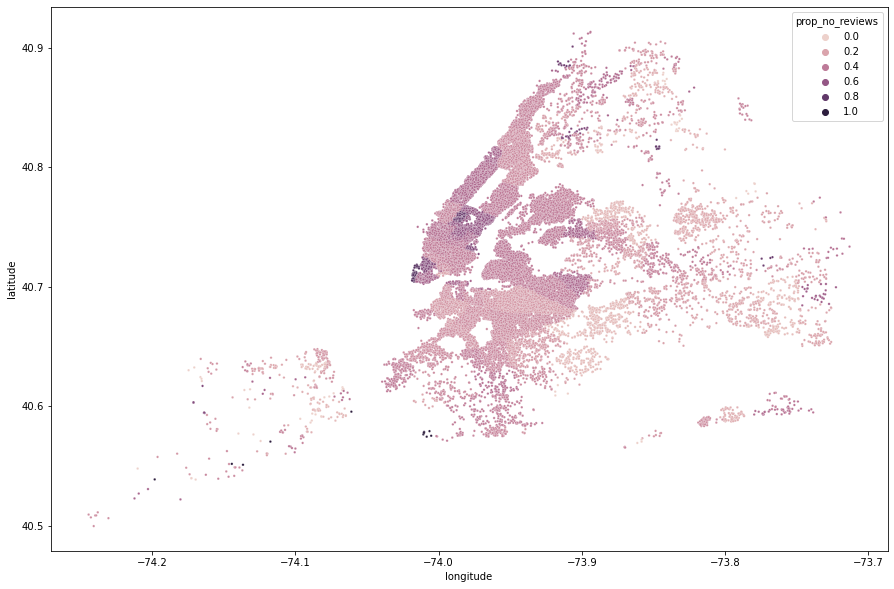

In [100]:
neighbourhoods = results_all[['neighbourhood', 'latitude', 'longitude']]

neighbourhoods = neighbourhoods.merge(group_prop_no_reviews(results_all, 'neighbourhood'), how = 'left', on = 'neighbourhood')

fig, ax = plt.subplots(figsize = (15,10))
sns.scatterplot(data = neighbourhoods,
                x='longitude', y = 'latitude', hue = 'prop_no_reviews', s = 6)

FixedFormatter should only be used together with FixedLocator


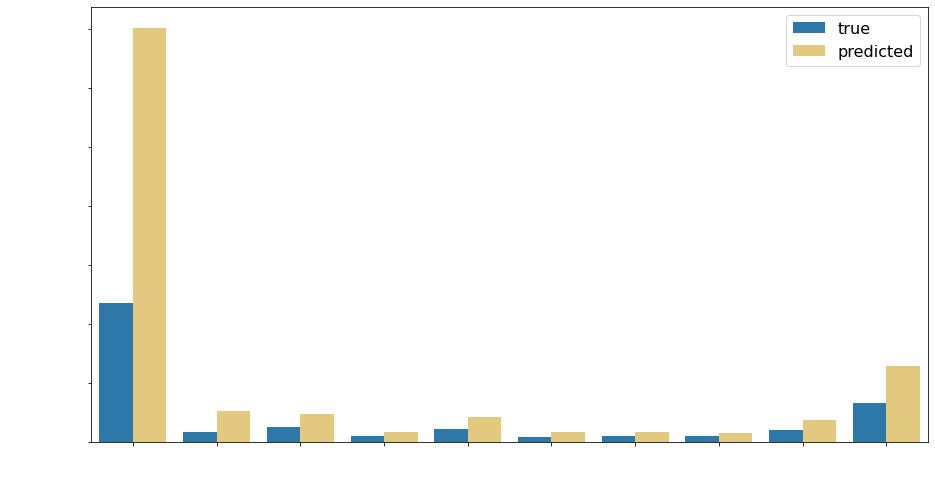

In [101]:
def categorise_variable(x):
    return math.floor(x*10)/10 if x <1 else 0.9

results['availability_frac'] = results['availability_365']/365
results['availability_cat'] = results['availability_frac'].apply(categorise_variable)

availability_with_reviews = results.groupby('availability_cat')[['y','y_pred']].sum()
availability_all = results.groupby('availability_cat')[['y', 'y_pred']].count()
availability_no_reviews = availability_all - availability_with_reviews
availability_no_reviews = availability_no_reviews.rename(
    columns = {'y': 'true', 'y_pred': 'predicted'}).reset_index(drop = False).melt(
    id_vars = ['availability_cat'],value_name = 'count', var_name = 'value')

avail_palette = {
    'true': '#197BBD',
    'predicted': '#F4D06F'
}

fig, ax = plt.subplots(figsize = (15,8))

sns.barplot(data = availability_no_reviews, x = 'availability_cat', y = 'count', hue = 'value', palette = avail_palette)
ax.set_xticklabels([
    '0-10%', '10-20%', '20-30%', '30-40%', 
    '40-50%', '50-60%', '60-70%', '70-80%', 
    '80-90%', '90-100%'
], 
    rotation = 0, fontsize = 16,
    color = 'white'
)

ax.set_xlabel(
    "Availability as percentage of the year", 
    fontsize = 16, 
    color = 'white'
)
ax.set_ylabel(
    "Count of listings that do not have reviews\n(or are predicted to not have reviews)",
    fontsize = 16, 
    color = 'white'
)
#ax.set_title("Comparison of true and predicted values of 'has reviews' for NYC listings\nby availability of the listing.")
plt.draw()

ax.set_yticklabels(ax.get_yticklabels(), color = 'white', fontsize = 16)
ax.legend(fontsize = 16);

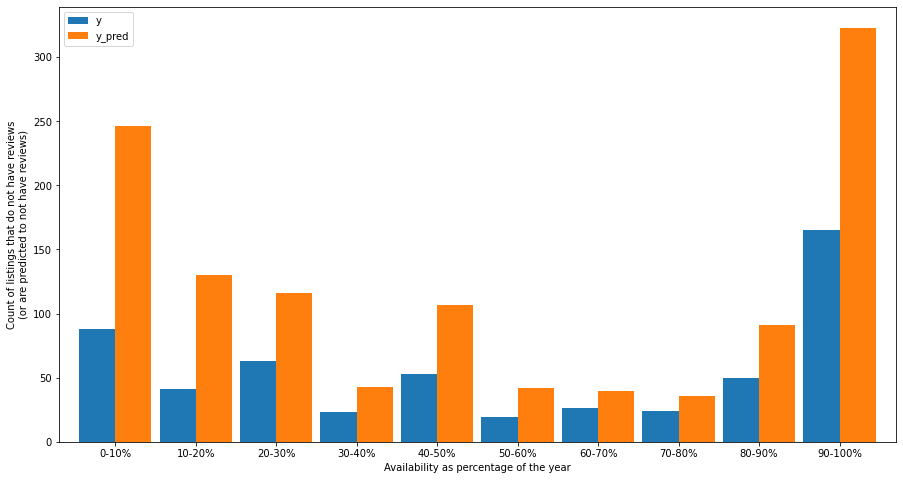

In [102]:
# REMOVE LISTINGS WHERE availability = 0
availability_with_reviews = results[results['availability_frac']!=0].groupby('availability_cat')[['y','y_pred']].sum()
availability_all = results[results['availability_frac']!=0].groupby('availability_cat')[['y', 'y_pred']].count()
availability_no_reviews = availability_all - availability_with_reviews

fig, ax = plt.subplots(figsize = (15,8))
availability_no_reviews.plot(kind = 'bar', ax = ax, width = 0.9)
ax.set_xticklabels([
    '0-10%', '10-20%', '20-30%', '30-40%', 
    '40-50%', '50-60%', '60-70%', '70-80%', 
    '80-90%', '90-100%'
], rotation = 0)
ax.set_xlabel("Availability as percentage of the year")
ax.set_ylabel("Count of listings that do not have reviews\n(or are predicted to not have reviews)");

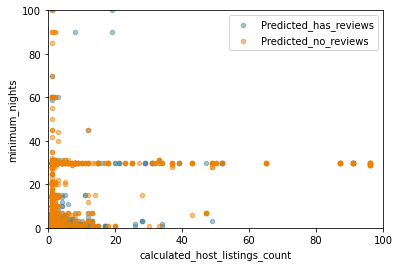

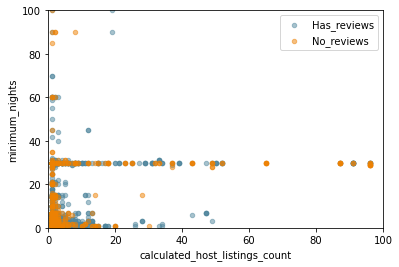

In [103]:
ax1 = plot_two_variables(results, 'calculated_host_listings_count', 'minimum_nights', 'y_pred', 'Predicted_has_reviews', 'Predicted_no_reviews')
ax2 = plot_two_variables(results, 'calculated_host_listings_count', 'minimum_nights', 'y', 'Has_reviews', 'No_reviews')
ax1.set_ylim(0,100)
ax2.set_ylim(0,100)
ax1.set_xlim(0,100)
ax2.set_xlim(0,100);

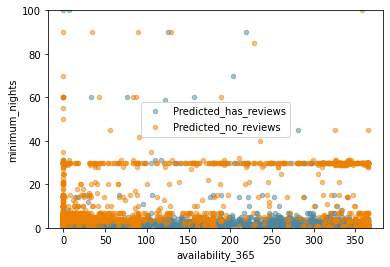

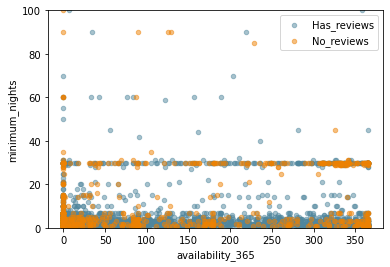

In [104]:
ax1 = plot_two_variables(results, 'availability_365', 'minimum_nights', 'y_pred', 'Predicted_has_reviews', 'Predicted_no_reviews')
ax2 = plot_two_variables(results, 'availability_365', 'minimum_nights',  'y', 'Has_reviews', 'No_reviews')
ax1.set_ylim(0,100)
ax2.set_ylim(0,100);

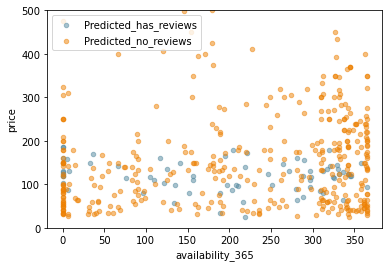

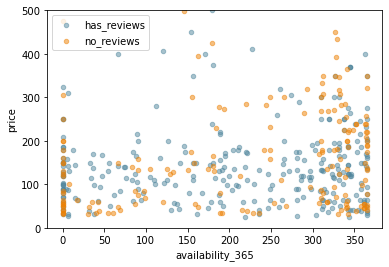

In [105]:
min_30 = results[results['minimum_nights']>=30]

ax1 = plot_two_variables(min_30, 'availability_365', 'price', 'y_pred', 'Predicted_has_reviews', 'Predicted_no_reviews')
ax2 = plot_two_variables(min_30, 'availability_365', 'price', 'y', 'has_reviews', 'no_reviews')

for ax in (ax1, ax2):
    ax.set_ylim(0,500);


In [106]:
#evaluate_model(model, min_30, min_30)

In [107]:
# this suggests that the model mostly predicts "no reviews" when minimum nights is greater than 30

results['at_least_30_nights'] = results['minimum_nights'].apply(lambda m: 0 if m<30 else 1)
results[results['at_least_30_nights']==1]['y'].value_counts()

1    285
0    180
Name: y, dtype: int64

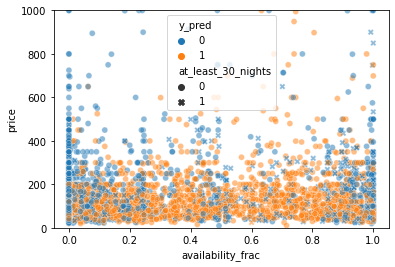

In [108]:
ax = sns.scatterplot(data = results, alpha = 0.5,
                x = 'availability_frac', y = 'price', hue = 'y_pred', style = 'at_least_30_nights')
ax.set_ylim(0,1000);

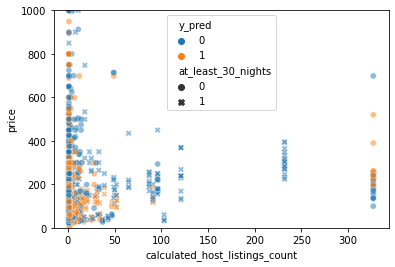

In [109]:
ax = sns.scatterplot(data = results, alpha = 0.5,
                x = 'calculated_host_listings_count', y = 'price', hue = 'y_pred', style = 'at_least_30_nights')
ax.set_ylim(0,1000);

In [110]:
X_test

,availability_frac,room_type_entire_home/apt,room_type_private_room,scaled_minimum_nights,scaled_calculated_host_listings_count,scaled_longitude,scaled_latitude,scaled_log_price
0,0.000000,0.0,1.0,0.013026,0.000000,0.334693,-0.420708,-1.042300
1,0.000000,0.0,1.0,0.013026,0.000000,0.286466,0.394349,-1.684343
2,0.854795,0.0,1.0,0.029058,0.030675,-0.189510,-0.641354,-0.259064
3,0.098630,0.0,1.0,0.020040,0.000000,0.032511,-0.335845,-0.637291
4,0.030137,0.0,1.0,0.001002,0.000000,0.369017,-0.823127,-0.259064
...,...,...,...,...,...,...,...,...
4395,0.342466,0.0,1.0,0.002004,0.000000,-1.012636,0.242872,-0.305199
4396,0.000000,0.0,1.0,0.000000,0.000000,1.011400,0.878529,-1.266302
4397,0.104110,0.0,0.0,0.006012,0.000000,0.089863,0.658978,-1.042300
4398,0.000000,1.0,0.0,0.002004,0.000000,-0.040482,-0.682235,0.621734


<AxesSubplot:xlabel='room_type', ylabel='price'>

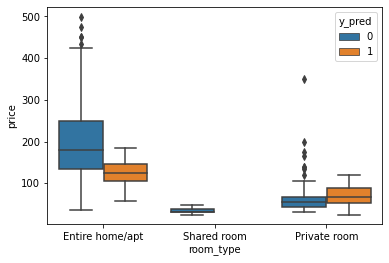

In [111]:
sns.boxplot(data = min_30[min_30['price']<500], x = 'room_type', y = 'price', hue = 'y_pred')

<AxesSubplot:xlabel='room_type', ylabel='price'>

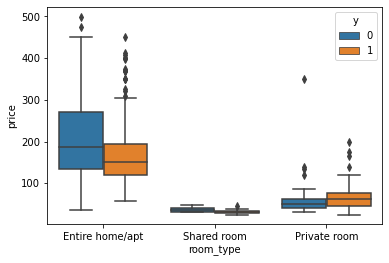

In [112]:
sns.boxplot(data = min_30[min_30['price']<500], x = 'room_type', y = 'price', hue = 'y')

(0.0, 40.0)

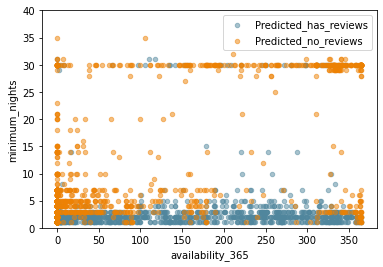

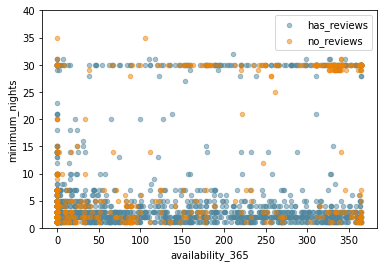

In [113]:
ax1 = plot_two_variables(results[results['room_type']=='Entire home/apt'], 'availability_365', 'minimum_nights', 'y_pred',  'Predicted_has_reviews', 'Predicted_no_reviews')
ax2 = plot_two_variables(results[results['room_type']=='Entire home/apt'], 'availability_365', 'minimum_nights', 'y',  'has_reviews', 'no_reviews')
ax1.set_ylim(0,40)
ax2.set_ylim(0,40)

(0.0, 1000.0)

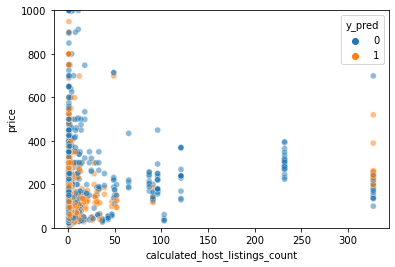

In [114]:
ax = sns.scatterplot(
    data = results, #[results['calculated_host_listings_count']>1],
    x = 'calculated_host_listings_count',
    y = 'price',
    hue = 'y_pred',
    #style = 'room_type',
    alpha = 0.5
)

ax.set_ylim(0,1000)
#ax.set_xlim();

(0.0, 1000.0)

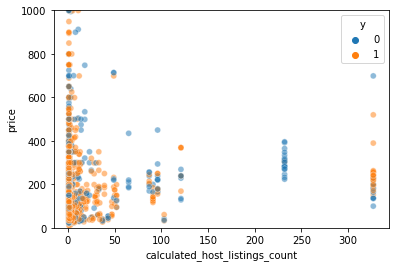

In [115]:
ax = sns.scatterplot(
    data = results, #[results['calculated_host_listings_count']>1],
    x = 'calculated_host_listings_count',
    y = 'price',
    hue = 'y',
    #style = 'room_type',
    alpha = 0.5
)
ax.set_ylim(0,1000)
#ax.set_xlim();

In [116]:
def evaluate_predictions(df):
    true_positives = df.copy()[(df['y']==1) & (df['y_pred']==1)]
    true_positives['result'] = 'true_pos'

    true_negatives = df.copy()[(df['y']==0) & (df['y_pred']==0)]
    true_negatives['result'] = 'true_neg'

    false_positives = df.copy()[(df['y']==0) & (df['y_pred']==1)]
    false_positives['result'] = 'false_pos'

    false_negatives = df.copy()[(df['y']==1) & (df['y_pred']==0)]
    false_negatives['result'] = 'false_neg'

    new_df = pd.concat([true_positives, true_negatives, false_positives, false_negatives], axis = 0).sort_index()
    return new_df
    
results_evaluated = evaluate_predictions(results)
results_evaluated['log_price'] = np.log(results_evaluated['price']+1)
results_evaluated.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,y,y_pred,availability_frac,availability_cat,at_least_30_nights,result,log_price
0,Manhattan,Chelsea,40.73778,-73.99616,Private room,99,12,4,29,1,1,0.079452,0.0,0,true_pos,4.605170
1,Manhattan,East Harlem,40.79142,-73.94664,Private room,90,2,4,237,1,1,0.649315,0.6,0,true_pos,4.510860
2,Brooklyn,Williamsburg,40.71906,-73.94394,Entire home/apt,80,30,8,97,1,1,0.265753,0.2,1,true_pos,4.394449
3,Manhattan,Washington Heights,40.84590,-73.94219,Private room,60,1,1,0,1,0,0.000000,0.0,0,false_neg,4.110874
4,Manhattan,Harlem,40.81249,-73.94175,Private room,90,4,2,365,0,0,1.000000,0.9,0,true_neg,4.510860


In [117]:
results_evaluated.groupby('result').count().iloc[:,0]

result
false_neg    1853
false_pos     221
true_neg      831
true_pos     1984
Name: neighbourhood_group, dtype: int64

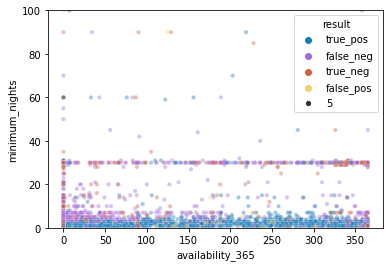

In [118]:
palette = {
    'true_pos' : '#197BBD',
    'true_neg' : '#D1603D',
    'false_pos': '#F4D06F',
    'false_neg': '#A367E0'
}

ax = sns.scatterplot(data = results_evaluated,
                    x = 'availability_365',
                    y = 'minimum_nights',
                    hue = 'result',
                    palette = palette,
                    alpha = 0.4,
                    size = 5);
ax.set_ylim(0,100);

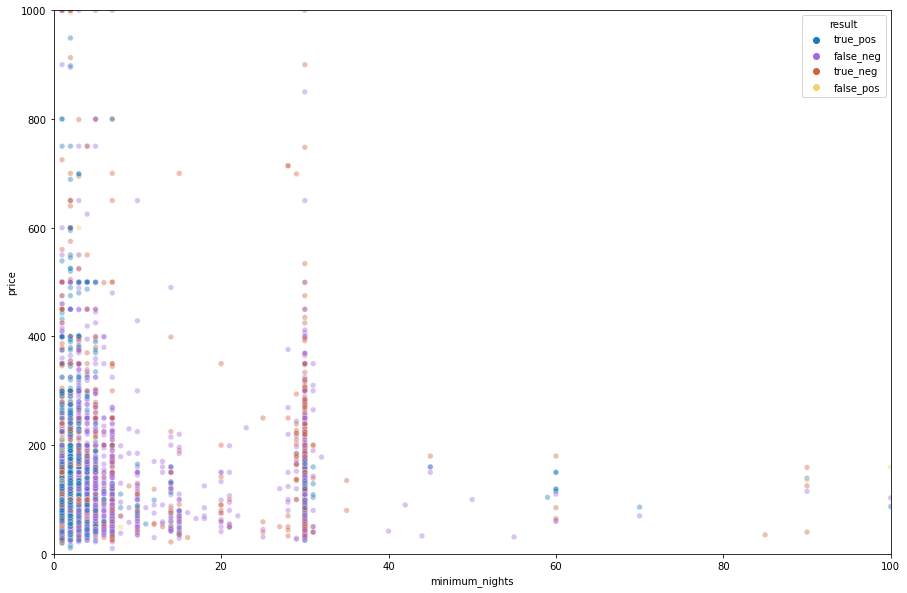

In [119]:
fig, ax = plt.subplots(figsize = (15,10))

sns.scatterplot(data = results_evaluated,
                    x = 'minimum_nights',
                    y = 'price',
                    hue = 'result',
                    palette = palette,
                    alpha = 0.4,
                    s = 30)

ax.set_ylim(0,1000)
ax.set_xlim(0,100);

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

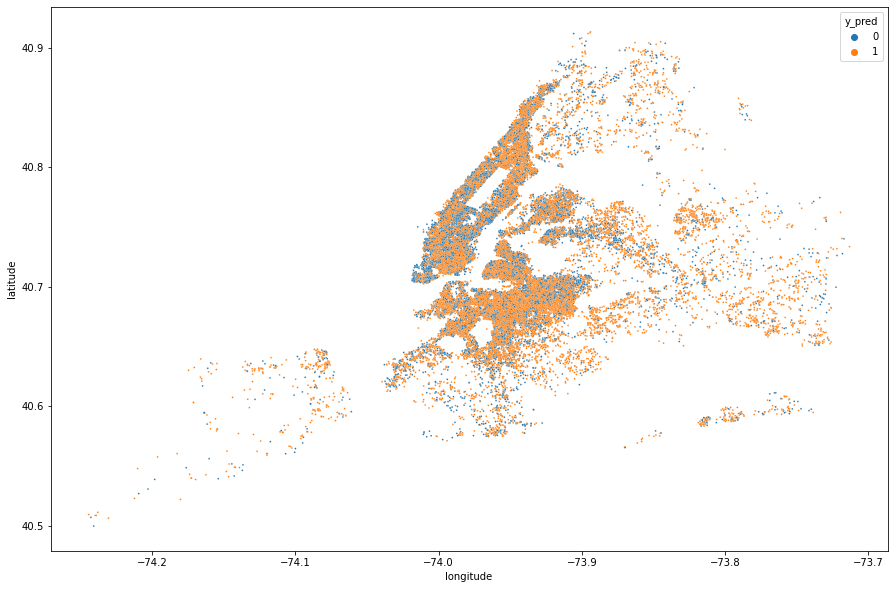

In [120]:
fig, ax = plt.subplots(figsize = (15,10))

sns.scatterplot(data = results_all, x = 'longitude', y = 'latitude', hue='y_pred', s = 3)

In [121]:
no_reviews = results_all[results_all['y']==0]
print(len(no_reviews))
print(len(no_reviews[no_reviews['availability_365']==0]))

10052
4845


In [122]:
10052-4845

5207

Before, the model captured 73% of the 'no review' listings. But 4000 of those were 'unavailable'

F1 scores for  Optimised XGboost on available properties only :

F1 score of negative class: 	 0.4553359683794467 
Macro average F1 score: 	 0.649032969352928


array([1, 1, 1, ..., 1, 1, 1])

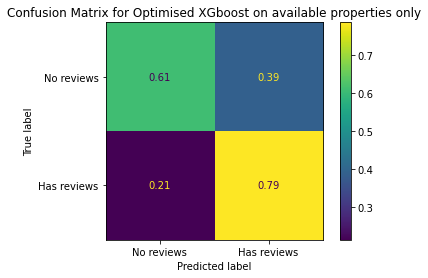

In [123]:
# out of interest
airbnb_encoded = encode_target(airbnb)
train_available, test_available = train_test_split(airbnb_encoded[airbnb['availability_365']>0], 
                                                   test_size = 0.2, random_state = 42)

y_train_available = train_available.pop('has_reviews')
X_train_available = apply_transformations(train_available.drop(['neighbourhood', 'neighbourhood_group'], axis = 1), 
                                          one_hot_encoder, minmax_scaler, standard_scaler, fit = True)
y_test_available = test_available.pop('has_reviews')
X_test_available = apply_transformations(test_available.drop(['neighbourhood', 'neighbourhood_group'], axis = 1), 
                                         one_hot_encoder, minmax_scaler, standard_scaler, fit = False)

prop_no_reviews_available = len(y_train_available[y_train_available==0])/len(y_train_available)

test_model = XGBClassifier(
    use_label_encoder = False, 
    eval_metric = 'logloss', 
    scale_pos_weight = prop_no_reviews_available, 
    seed = 42
)

test_model.fit(X_train_available, y_train_available)

evaluate_model(test_model, X_test_available, y_test_available, "Optimised XGboost on available properties only")

In [124]:
# Warning! GridSearchCV in use, this cell takes a long time to run!

params = {
    'max_depth': [2,4,6,8],
    'learning_rate': [0.1,0.2,0.4,0.8],
    'objective': ['reg:squarederror', 'binary:logistic'],
    'tree_method': ['exact', 'hist']
}

custom_scorer = make_scorer(f1_score, pos_label = 0)

model_optimised = GridSearchCV(test_model, params, scoring = custom_scorer).fit(X_train_available, y_train_available)


F1 scores for  Optimised XGboost on available properties only :

F1 score of negative class: 	 0.46153846153846156 
Macro average F1 score: 	 0.6528315808891348


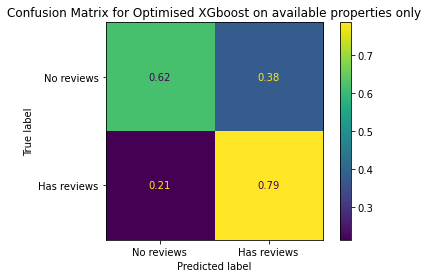

In [125]:
test_model.set_params(**model_optimised.best_params_)
test_model.fit(X_train_available, y_train_available)

y_pred = evaluate_model(test_model, X_test_available, y_test_available, "Optimised XGboost on available properties only")


In [126]:
test_available.reset_index(drop = True, inplace = True)
test_available['y'] = y_test_available.reset_index(drop = True)
test_available['y_pred'] = y_pred

available_eval = evaluate_predictions(test_available)
available_eval

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,y,y_pred,result
0,Brooklyn,Williamsburg,40.70930,-73.96484,Private room,123,3,3,158,1,1,true_pos
1,Manhattan,East Harlem,40.79805,-73.93399,Entire home/apt,379,4,1,219,1,1,true_pos
2,Queens,Rockaway Beach,40.58954,-73.81361,Entire home/apt,125,1,1,67,0,1,false_pos
3,Manhattan,Upper West Side,40.80319,-73.96676,Private room,70,15,12,153,0,1,false_pos
4,Queens,Richmond Hill,40.70288,-73.81955,Entire home/apt,104,2,2,65,1,1,true_pos
...,...,...,...,...,...,...,...,...,...,...,...,...
5641,Manhattan,Lower East Side,40.72017,-73.98412,Private room,90,2,1,60,1,1,true_pos
5642,Manhattan,Chinatown,40.71522,-73.99355,Private room,90,1,2,125,1,1,true_pos
5643,Brooklyn,Brighton Beach,40.58022,-73.95580,Entire home/apt,75,2,1,169,1,1,true_pos
5644,Brooklyn,Greenpoint,40.73660,-73.95656,Entire home/apt,225,4,1,159,0,1,false_pos


In [127]:
test_has_reviews = available_eval[available_eval['y']==1]

print(len(test_has_reviews[test_has_reviews['y_pred']==1])/len(test_has_reviews))
print(len(test_has_reviews[test_has_reviews['y_pred']==0])/len(test_has_reviews))

test_has_reviews['y_pred'].value_counts()

0.785881352328301
0.21411864767169891


1    3696
0    1007
Name: y_pred, dtype: int64

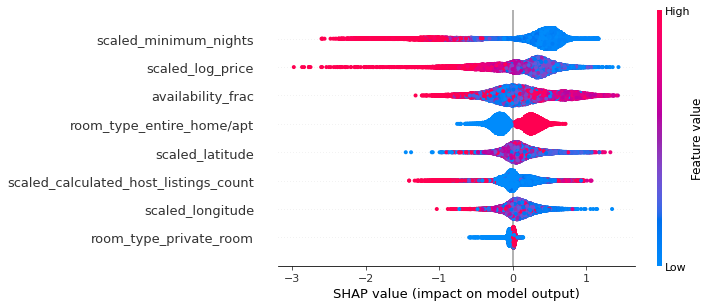

In [128]:
shap_values = shap.TreeExplainer(test_model).shap_values(X_train_available) 
shap.summary_plot(shap_values, X_train_available)

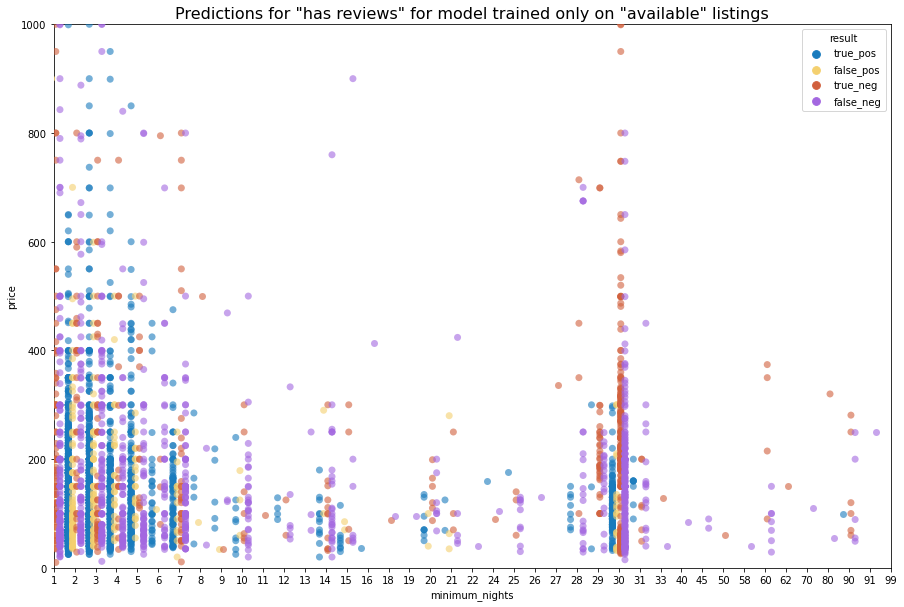

In [129]:
fig, ax = plt.subplots(figsize = (15,10))
sns.stripplot(data = available_eval,
                x = 'minimum_nights', y = 'price', hue = 'result', s=7, alpha = 0.6,
                dodge = True, jitter = False, palette = palette)
ax.set_ylim(0,1000)
ax.set_xlim(0,40)
ax.set_title('Predictions for "has reviews" for model trained only on "available" listings', fontsize = 16);

In [130]:
#categorise minimum nights
def min_nights_categorise(nights):
    if nights <=3:
        return "1-3"
    elif nights <= 29:
        return "4-29"
    else:
        return "30+"

available_eval['minimum_nights_cat'] = available_eval['minimum_nights'].apply(min_nights_categorise)

results_by_min_nights = available_eval.groupby(['minimum_nights_cat', 'result'])['y'].count().reset_index(drop = False).rename(columns = {'y': 'count'})
results_by_min_nights

,minimum_nights_cat,result,count
0,1-3,false_neg,366
1,1-3,false_pos,265
2,1-3,true_neg,153
3,1-3,true_pos,2903
4,30+,false_neg,264
5,30+,false_pos,20
6,30+,true_neg,287
7,30+,true_pos,161
8,4-29,false_neg,377
9,4-29,false_pos,73


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


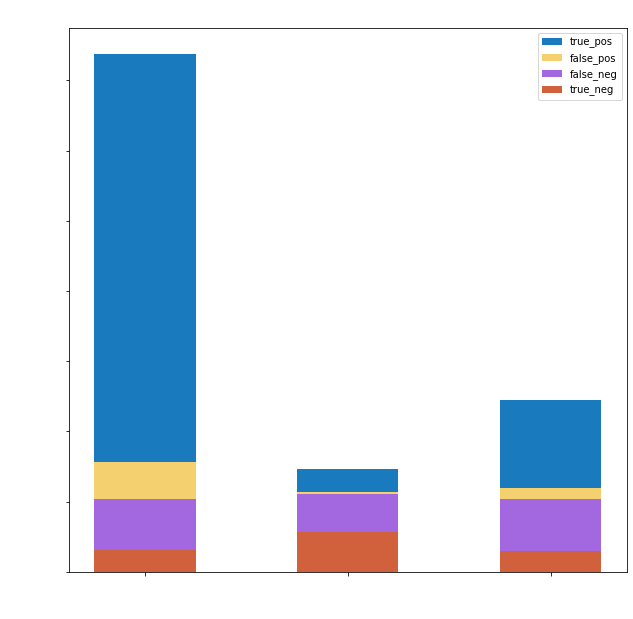

In [131]:
possible_results = ['true_neg', 'false_neg', 'false_pos', 'true_pos']
labels = ['1-3', '4-29', '30+']

fig, ax = plt.subplots(figsize = (10,10))

for i in range(4):
    temp = results_by_min_nights[results_by_min_nights['result'] == possible_results[i]]
    if i==0:
        bottom = [0] * len(temp)
    ax.bar(labels, temp['count'], width=0.5, bottom=bottom, label=possible_results[i], color = palette[possible_results[i]])
    bottom = [x + y for x,y in zip(bottom, temp['count'])]

ax.set_xlabel('Minimum nights group', fontsize = 16, color = 'white')
ax.set_ylabel('Count', fontsize = 16, color = 'white')
ax.set_title('Prediction results by minimum night grouping', fontsize = 20, color = 'white')
ax.set_xticklabels(labels, fontsize = 14, color= 'white')

ax.legend(fontsize = 16)

plt.draw()

ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14, color = 'white')

handles, labels = ax.get_legend_handles_labels()

# reverse the order
ax.legend(handles[::-1], labels[::-1]);

FixedFormatter should only be used together with FixedLocator


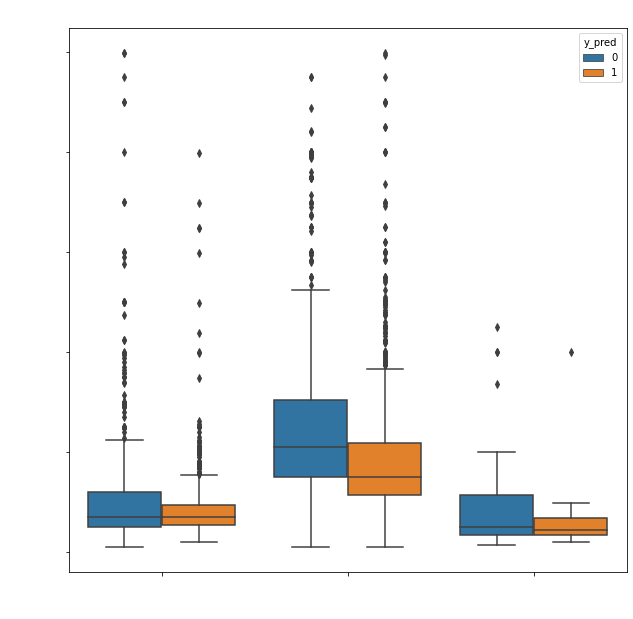

In [132]:
fig, ax = plt.subplots(figsize = (10,10))
sns.boxplot(data = available_eval[available_eval['price']<1000], x = 'room_type', y = 'price', hue = 'y_pred')

#ax.legend(title = 'Prediction', labels = ['no reviews', 'has reviews'], fontsize = 16)

ax.set_xlabel('Listing Type', fontsize = 16, color = 'white')
ax.set_ylabel('Price', fontsize = 16, color = 'white')
ax.set_title("Distribution of prices for different room types", fontsize = 20, color = 'white')
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14, color= 'white')

plt.draw()

ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14, color = 'white');

FixedFormatter should only be used together with FixedLocator


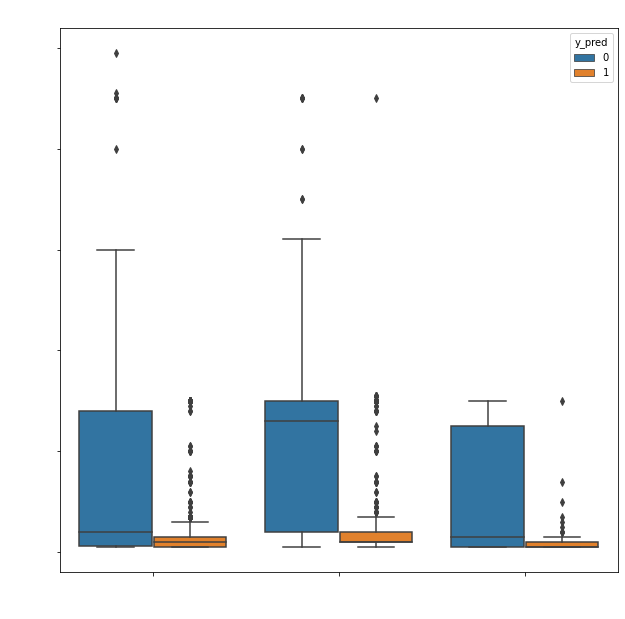

In [133]:
fig, ax = plt.subplots(figsize = (10,10))
sns.boxplot(data = available_eval[available_eval['minimum_nights']<100], x = 'room_type', y = 'minimum_nights', hue = 'y_pred')

#ax.legend(title = 'Prediction', labels = ['no reviews', 'has reviews'], fontsize = 16)

ax.set_xlabel('Listing Type', fontsize = 16, color = 'white')
ax.set_ylabel('Minimum nights', fontsize = 16, color = 'white')
ax.set_title("Distribution of minimum nights for different room types", fontsize = 20, color = 'white')
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14, color= 'white')

plt.draw()

ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14, color = 'white');

In [134]:
results_by_room_type = available_eval.groupby(['room_type', 'result'])['y'].count().reset_index(drop = False).rename(columns = {'y': 'count'})
count_room_types = available_eval.groupby(['room_type'])['y'].count().reset_index(drop = False).rename(columns = {'y': 'total'})

results_by_room_type = results_by_room_type.merge(count_room_types, how = 'left', on = 'room_type')
results_by_room_type['proportion_of_room_type'] = results_by_room_type['count']/results_by_room_type['total']
results_by_room_type

,room_type,result,count,total,proportion_of_room_type
0,Entire home/apt,false_neg,514,2994,0.171677
1,Entire home/apt,false_pos,182,2994,0.060788
2,Entire home/apt,true_neg,332,2994,0.110888
3,Entire home/apt,true_pos,1966,2994,0.656647
4,Private room,false_neg,463,2498,0.185348
5,Private room,false_pos,163,2498,0.065252
6,Private room,true_neg,230,2498,0.092074
7,Private room,true_pos,1642,2498,0.657326
8,Shared room,false_neg,30,154,0.194805
9,Shared room,false_pos,13,154,0.084416


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


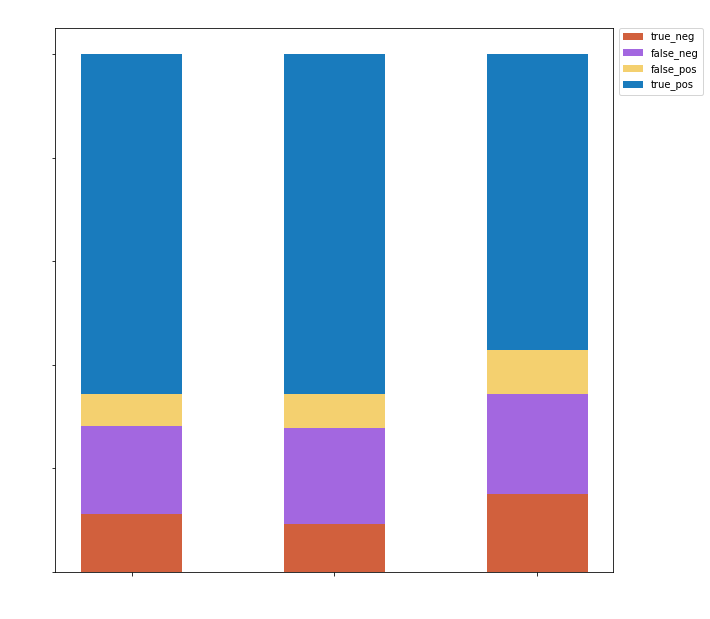

In [135]:
possible_results = ['true_neg', 'false_neg', 'false_pos', 'true_pos']
labels = ['Private room', 'Entire home/apt', 'Shared room']

fig, ax = plt.subplots(figsize = (10,10))

for i in range(4):
    temp = results_by_room_type[results_by_room_type['result'] == possible_results[i]]
    if i==0:
        bottom = [0] * len(temp)
    ax.bar(labels, temp['proportion_of_room_type'], width=0.5, bottom=bottom, label=possible_results[i], color = palette[possible_results[i]])
    bottom = [x + y for x,y in zip(bottom, temp['proportion_of_room_type'])]

ax.set_ylabel('Count', fontsize = 16, color = 'white')
ax.set_title('Prediction results by room type', fontsize = 20, color = 'white')
ax.set_xlabel('Listing type', fontsize = 16, color = 'white')

plt.draw()

ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14, color = 'white')
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 14, color = 'white')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize = 16)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0);

(0.0, 1000.0)

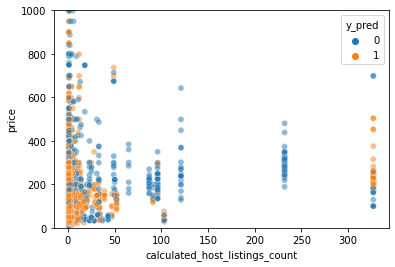

In [136]:
ax = sns.scatterplot(
    data = available_eval, #[results['calculated_host_listings_count']>1],
    x = 'calculated_host_listings_count',
    y = 'price',
    hue = 'y_pred',
    #style = 'room_type',
    alpha = 0.5
)

ax.set_ylim(0,1000)
#ax.set_xlim();

(0.0, 1000.0)

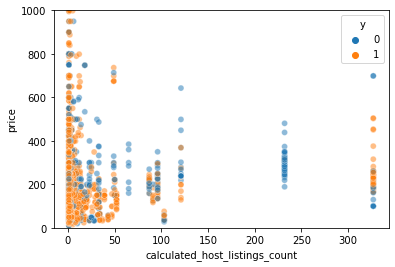

In [137]:
ax = sns.scatterplot(
    data = available_eval, #[results['calculated_host_listings_count']>1],
    x = 'calculated_host_listings_count',
    y = 'price',
    hue = 'y',
    #style = 'room_type',
    alpha = 0.5
)

ax.set_ylim(0,1000)
#ax.set_xlim();

In [138]:
test_o_r = OutlierRemover(min_z_score = -4, max_z_score = 4)

test_airbnb = apply_transformations(
    airbnb.drop(['neighbourhood_group', 'neighbourhood'])
)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
42293,Manhattan,Kips Bay,40.74434,-73.97758,Shared room,53,2,2,3,297
39716,Manhattan,Upper East Side,40.77382,-73.95350,Entire home/apt,160,2,6,1,11
10648,Brooklyn,Williamsburg,40.71321,-73.94099,Private room,60,1,0,2,0
45820,Brooklyn,Bedford-Stuyvesant,40.68414,-73.93538,Entire home/apt,140,6,0,1,252
28309,Manhattan,Harlem,40.81083,-73.95248,Private room,69,2,0,1,0


## Multi-label classification

Following a question asked after the presentation, I decided to attempt multi-label classification to see if different numbers of reviews could be detected.

In [151]:
airbnb = pd.read_csv(path_to_dataset).drop(['id', 'name', 'host_name', 'host_id'], axis = 1)

airbnb.fillna(0, inplace = True)

airbnb = airbnb[airbnb['price']>0]

airbnb.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [143]:
avg_month_length = (31+28.25+31+30+31+30+31+31+30+31+30+31)/12

airbnb['minimum_stay_months'] = airbnb['minimum_nights']/avg_month_length


30.4375